In [1]:
import os
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib import cm
from matplotlib.colors import Normalize

DATA_DIR = 'Data/'
FIG_DIR = 'Results/3.3/'
data_name = [r'2M_0.02/summary.txt',r'30M_0.02/summary.txt']


plt.style.use('matplotlib.mplstyle')

col_names = ['Step','t','M','LogL','LogR',
                 'LogTs','LogTc','Logrhoc','logPc','psic',
                 'Xc','Yc','XCc','XNc','XOc',
                 'taudyn','tauKH','taunuc','Lpp','LCNO',
                 'L3a','LZ','Lv','MHe','MC',
                 'MO','RHe','RC','RO']

col_names_structure = ['Mr','r','Lr','P','rho',
                 'T','U','S','Cp','adia1',
                 'nablaad','mu','ne','Pe','Pr',
                 'nablarad','nabla','vc','kappa','epsnuc',
                 'epspp','epscno','eps3alpha','epsvnuc','epsv', 'epsgrav',
                 'X','-','X+','Y', 'Y+', 'Y++', 'XC', 'XN', 'XO', 'Psi']

plot_title = [r'$2\mathrm{M_\odot}$',r'$30\mathrm{M_\odot}$']

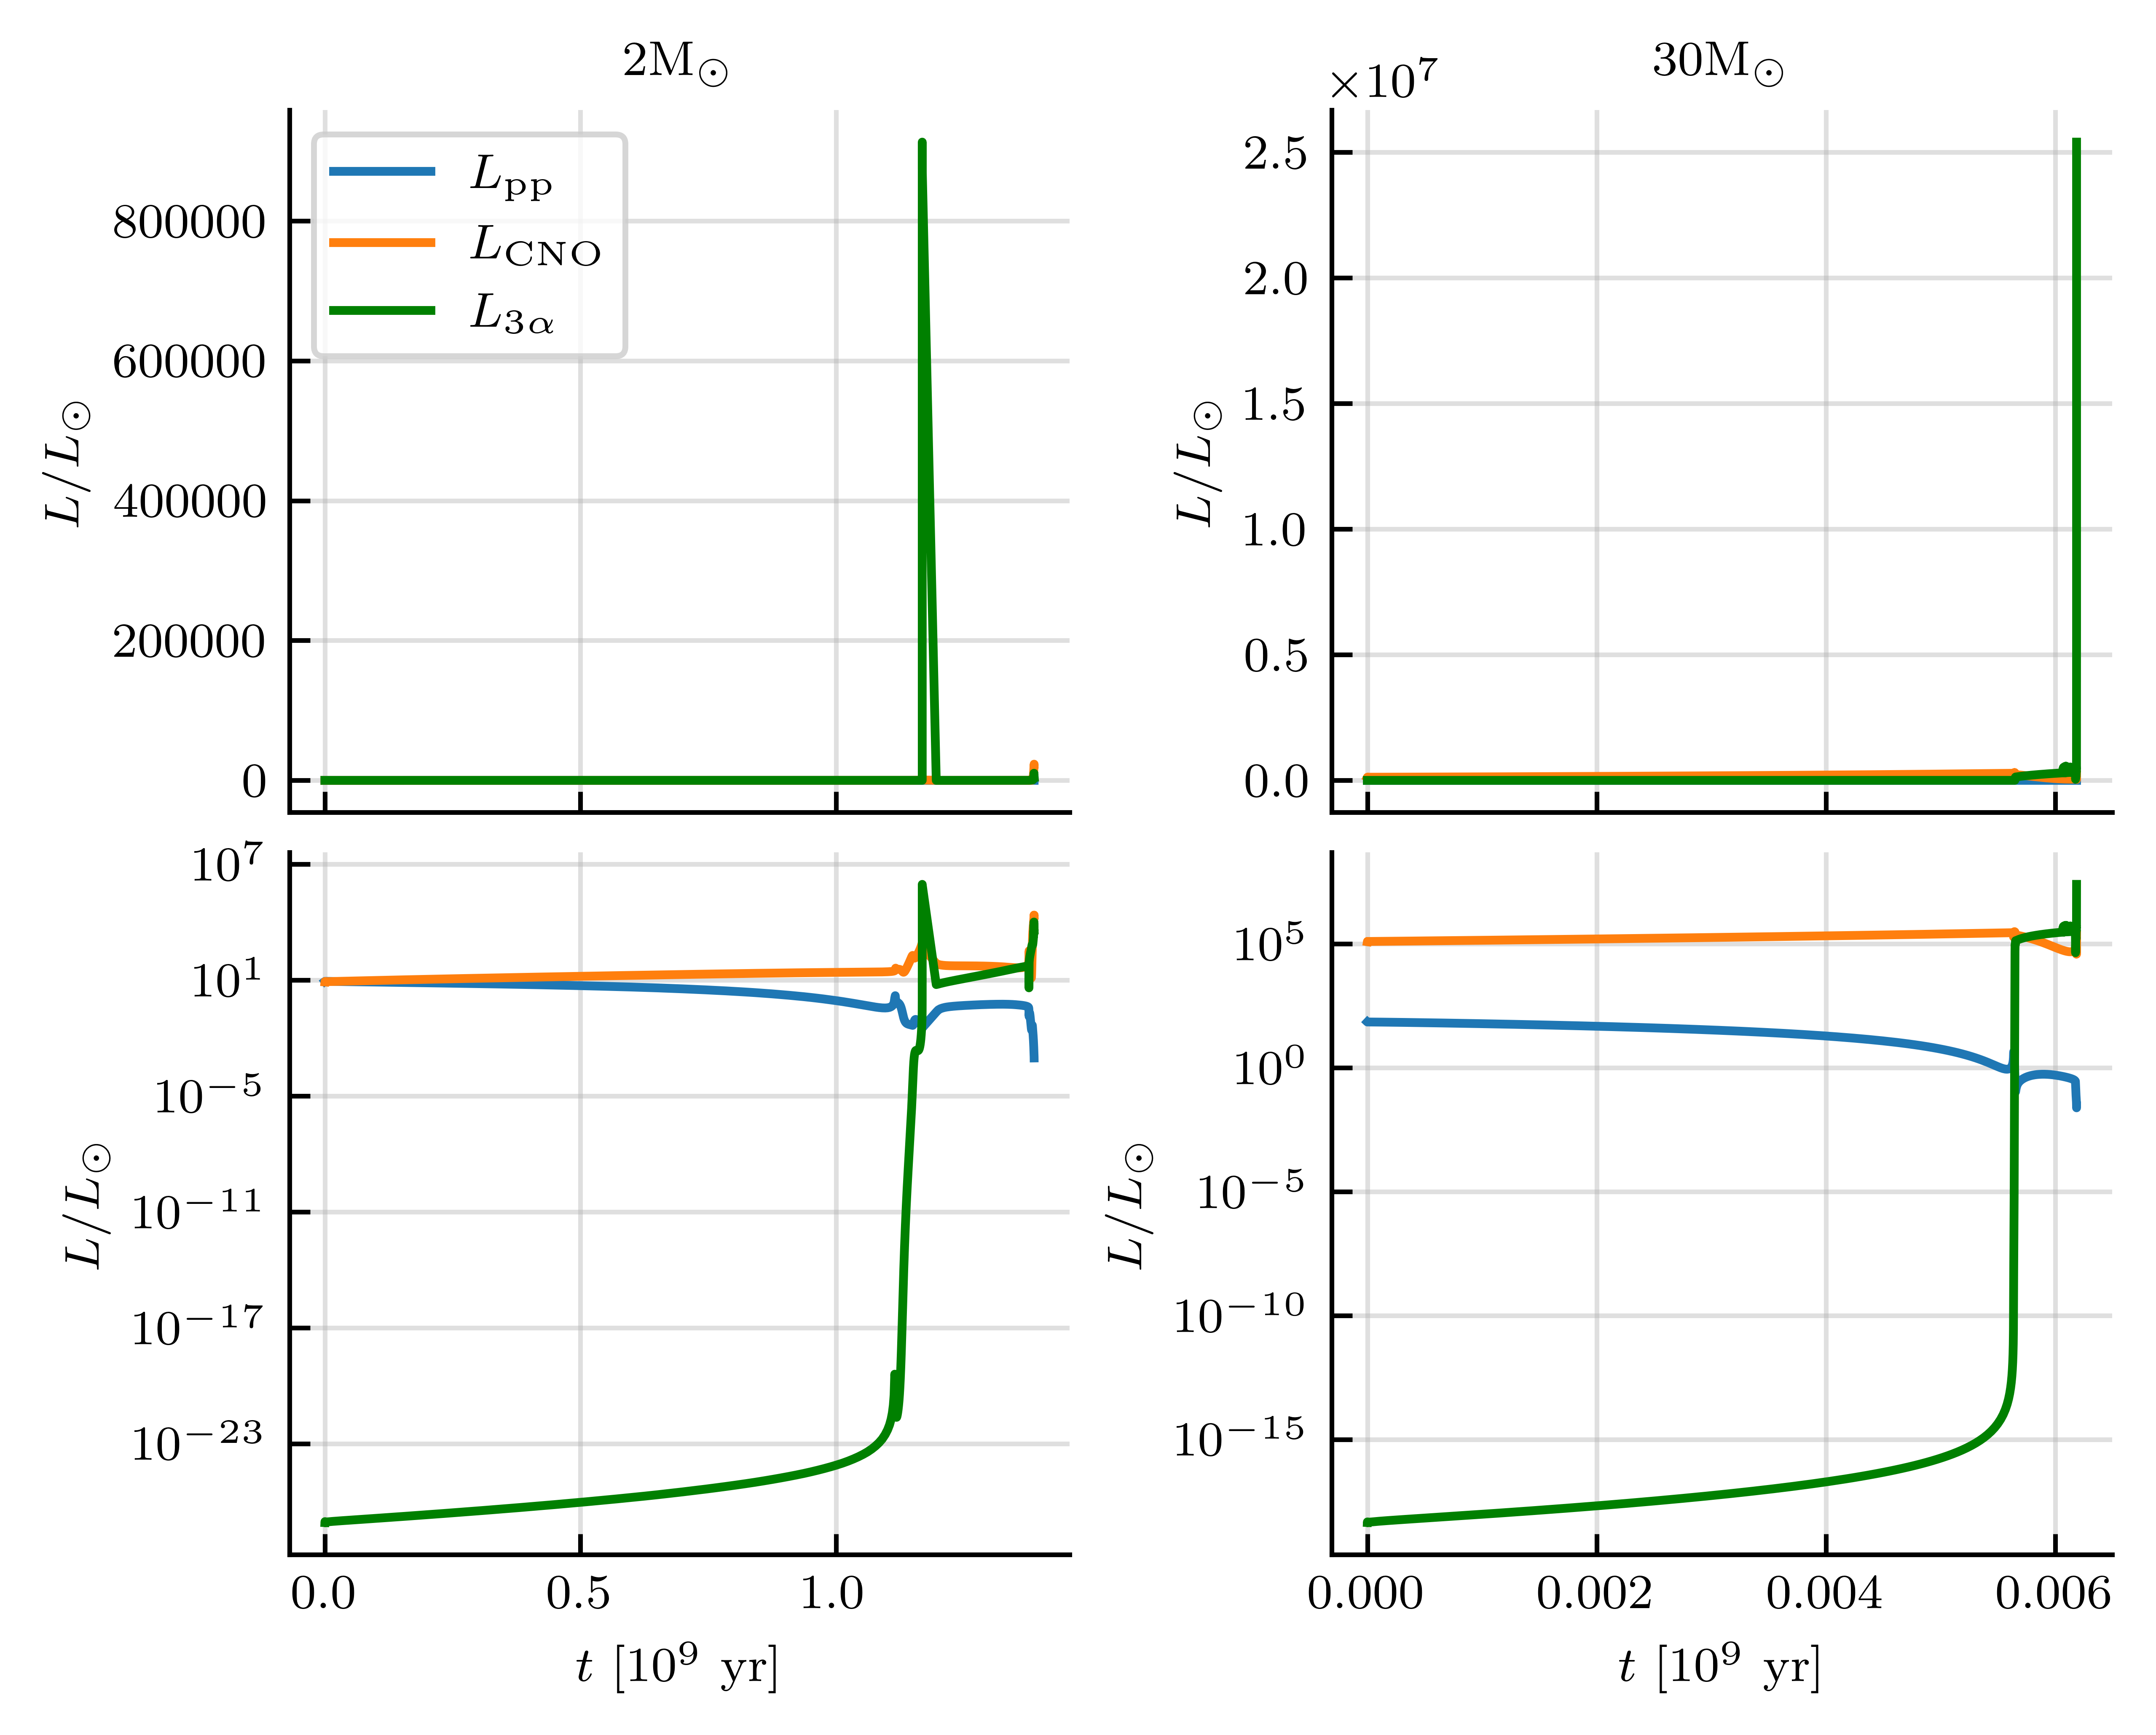

In [2]:
# The straight values for the luminosity-contributions

def plot_lum_values(data_files, data_dir):
    fig, axs = plt.subplots(2,2, figsize=(5,4), sharex='col')
    
    for i, data_name in enumerate(data_files):
        
        df = pd.read_csv(data_dir + data_name, sep=r'\s+', header=None)
        df.columns = col_names
        df.drop(columns=['Step'], inplace=True)
        
        #Plotting the luminosity values normally 
        axs[0,i].plot(df['t'] / 1e9, df['Lpp'], label = r'$L_{\mathrm{pp}}$')
        axs[0,i].plot(df['t'] / 1e9, df['LCNO'], label = r'$L_{\mathrm{CNO}}$')
        axs[0,i].plot(df['t'] / 1e9, df['L3a'], color = 'g', label = r'$L_{3\alpha}$')
        axs[0,i].set_ylabel(r"$L/L_\odot$")
        #axs[0,i].set_xlabel(r"$t \ [\mathrm{10^9 \ yr}]$")
        
        #Plotting on a log-scale for readability and comparison
        axs[1,i].semilogy(df['t'] / 1e9, df['Lpp'], label = r'$L_{\mathrm{pp}}$')
        axs[1,i].semilogy(df['t'] / 1e9, df['LCNO'], label = r'$L_{\mathrm{CNO}}$')
        axs[1,i].semilogy(df['t'] / 1e9, df['L3a'], color = 'g', label = r'$L_{3\alpha}$')
        axs[1,i].set_ylabel(r"$L/L_\odot$")
        axs[1,i].set_xlabel(r"$t \ [\mathrm{10^9 \ yr}]$")
        
        axs[0,i].set_title(plot_title[i])
        axs[0,i].grid(which='both', alpha=0.4, visible=True)
        axs[1,i].grid(which='both', alpha=0.4, visible=True)
    
    axs[0,0].legend()
    
    #plt.suptitle('Luminosity contribution over time for nuclear processes')
    plt.savefig(FIG_DIR+'L different processes.pdf',bbox_inches='tight')
    
plot_lum_values(data_name, DATA_DIR)

0
1


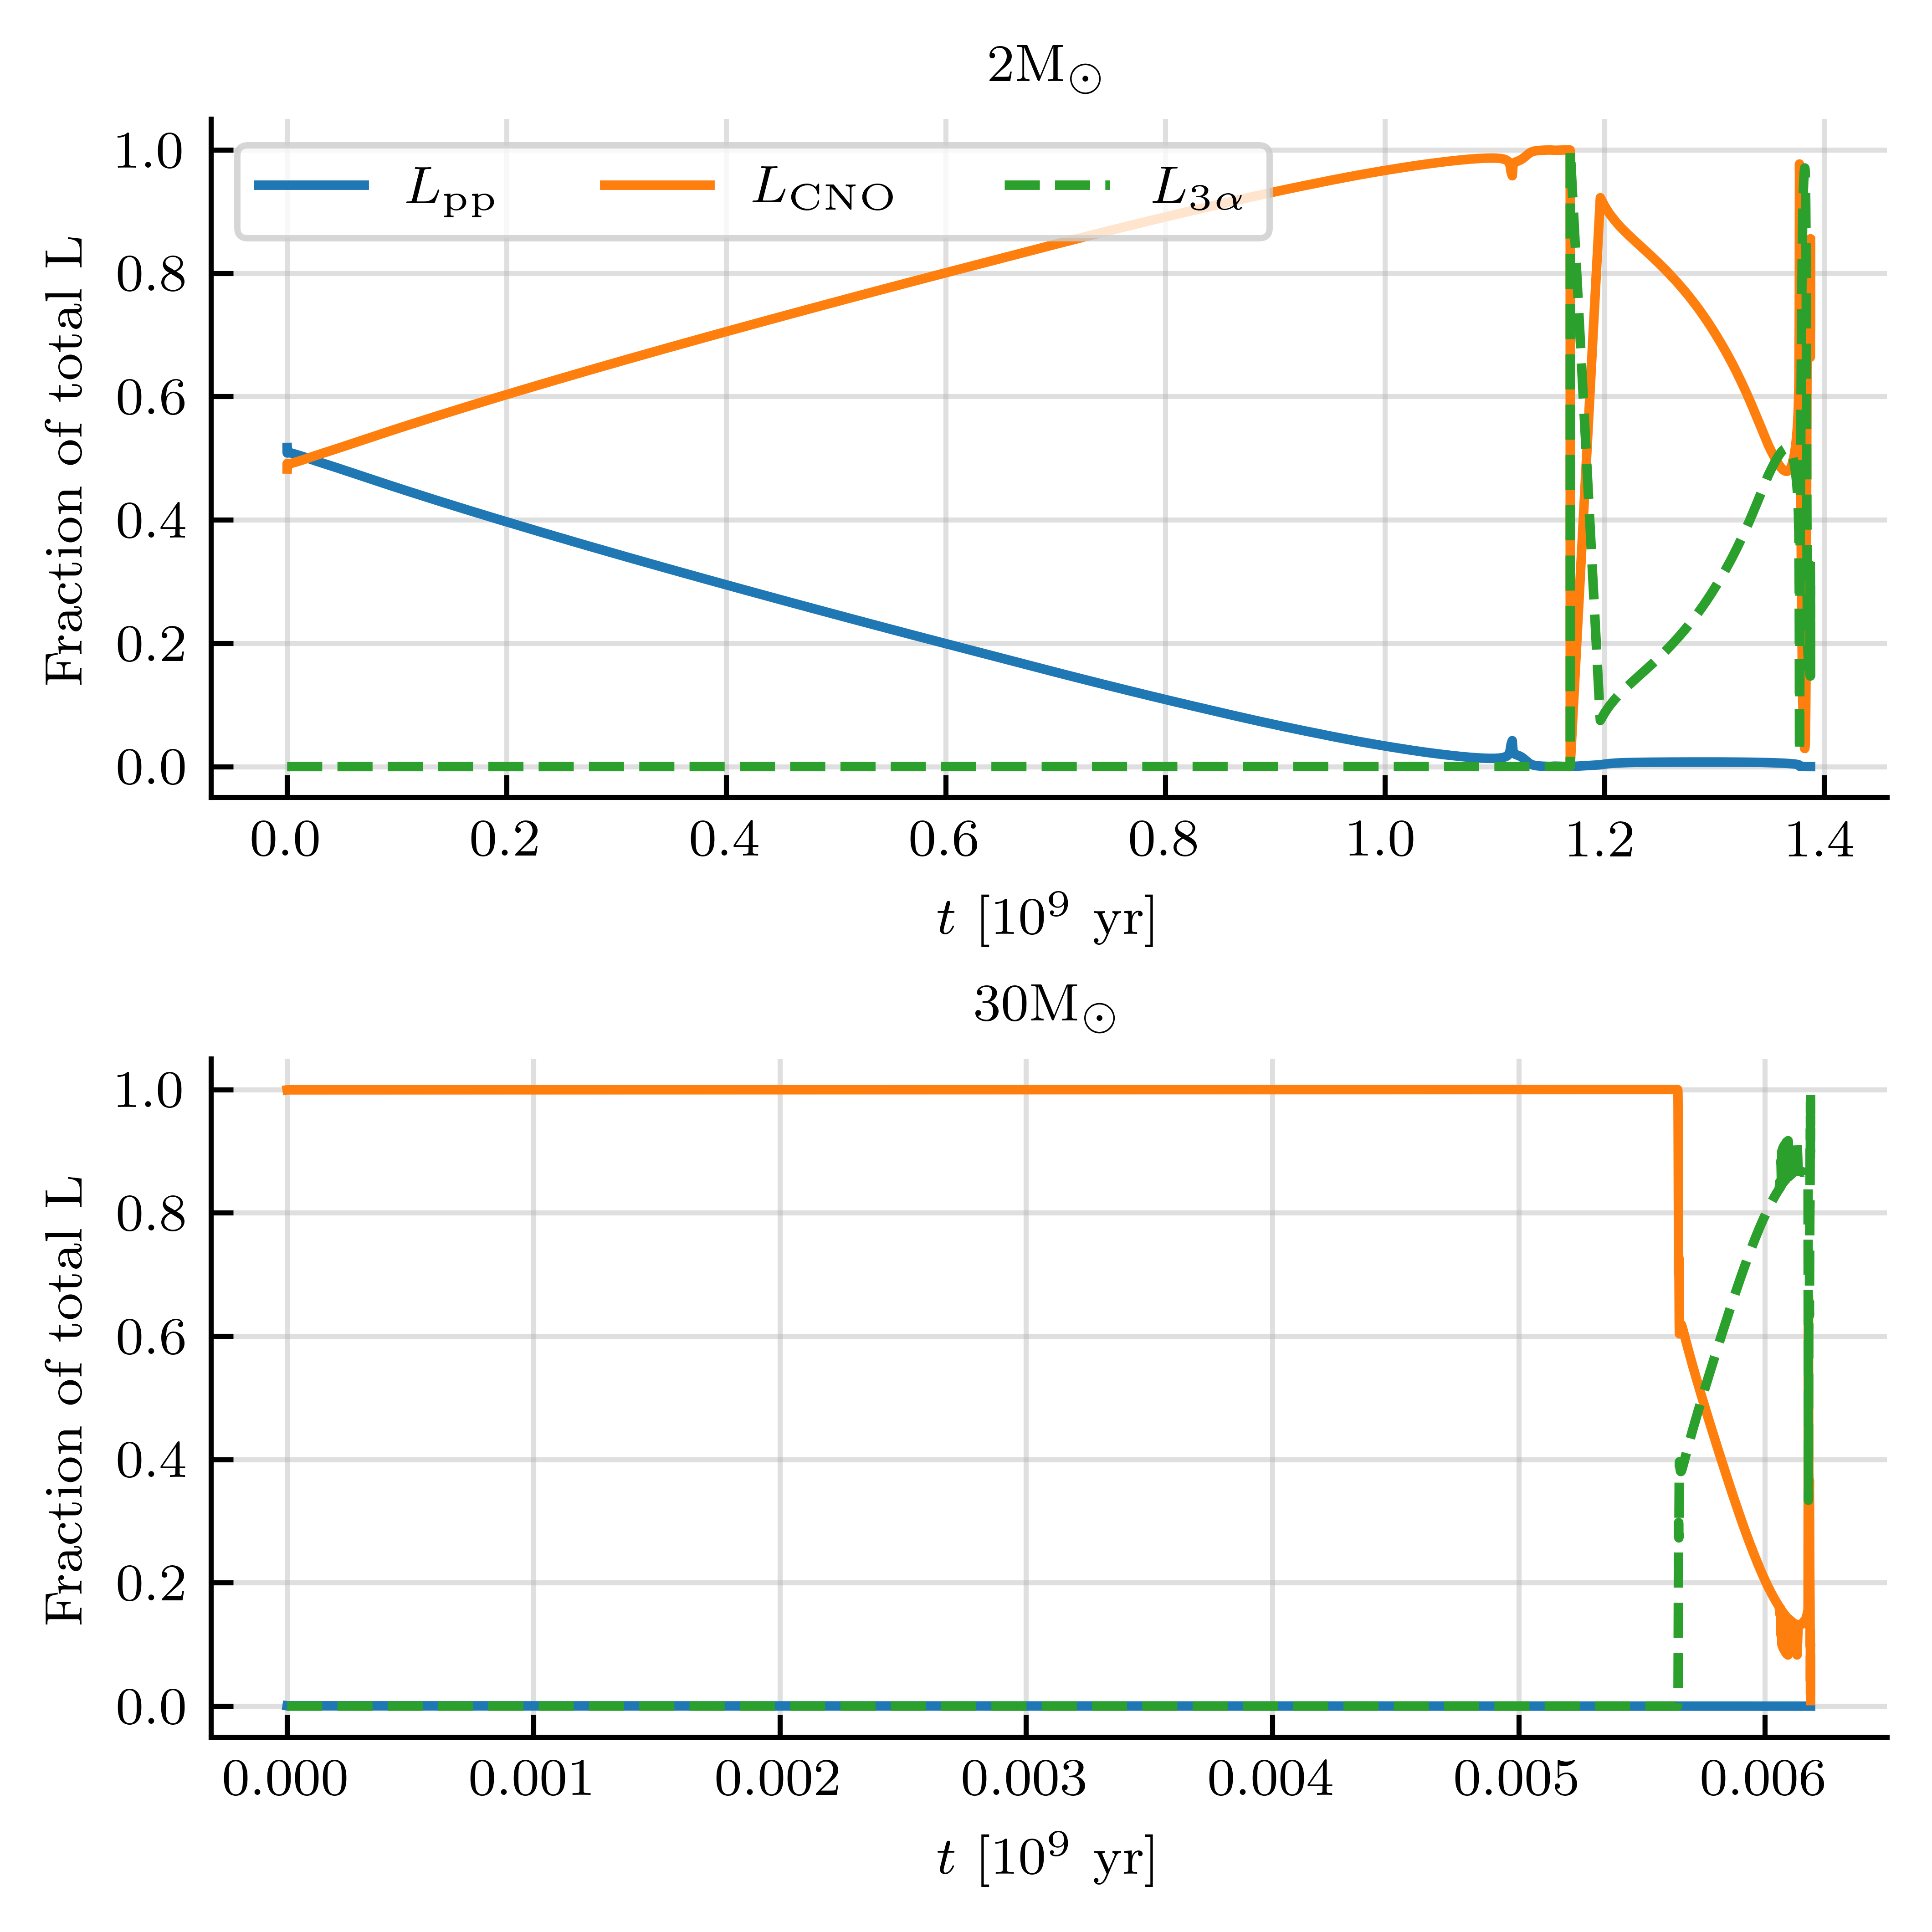

In [6]:
# Proportion of luminosity contribution

def plot_lum_prop(data_files, data_dir):
    fig, axs = plt.subplots(2,figsize=(4.125,4.125))
    
    for i, data_name in enumerate(data_files):
        df = pd.read_csv(data_dir + data_name, sep=r'\s+', header=None)
        df.columns = col_names
        df.drop(columns=['Step'], inplace=True)
        
        #Normalising values at each time-step
        for j in range(len(df['Lpp'])):
            tot  = df['Lpp'][j] + df['LCNO'][j] + df['L3a'][j]
            df.loc[j, "Lpp"] = df.loc[j, "Lpp"]/tot
            df.loc[j,'LCNO'] = df.loc[j,'LCNO']/tot
            df.loc[j,'L3a'] = df.loc[j,'L3a']/tot
            
        print(i)
        axs[i].plot(df['t'] / 1e9, df['Lpp'], label = r'$L_{\mathrm{pp}}$')
        
        axs[i].plot(df['t'] / 1e9, df['LCNO'], label = r'$L_{\mathrm{CNO}}$')
        
        axs[i].plot(df['t'] / 1e9, df['L3a'], linestyle = '--', label = r'$L_{3\alpha}$')
        
        axs[i].set_ylabel(r"Fraction of total L")
        axs[i].set_xlabel(r"$t \ [\mathrm{10^9 \ yr}]$")
    
        axs[i].set_title(plot_title[i])
        axs[i].grid(which='both', alpha=0.4, visible=True)
    axs[0].legend([r'$L_{\mathrm{pp}}$',r'$L_{\mathrm{CNO}}$',r'$L_{3\alpha}$'], loc='upper left', ncol=3)
    #plt.suptitle('Proportion of the luminosity contribution')
    plt.savefig(FIG_DIR+'L proportions.pdf',bbox_inches='tight')


plot_lum_prop(data_name, DATA_DIR)

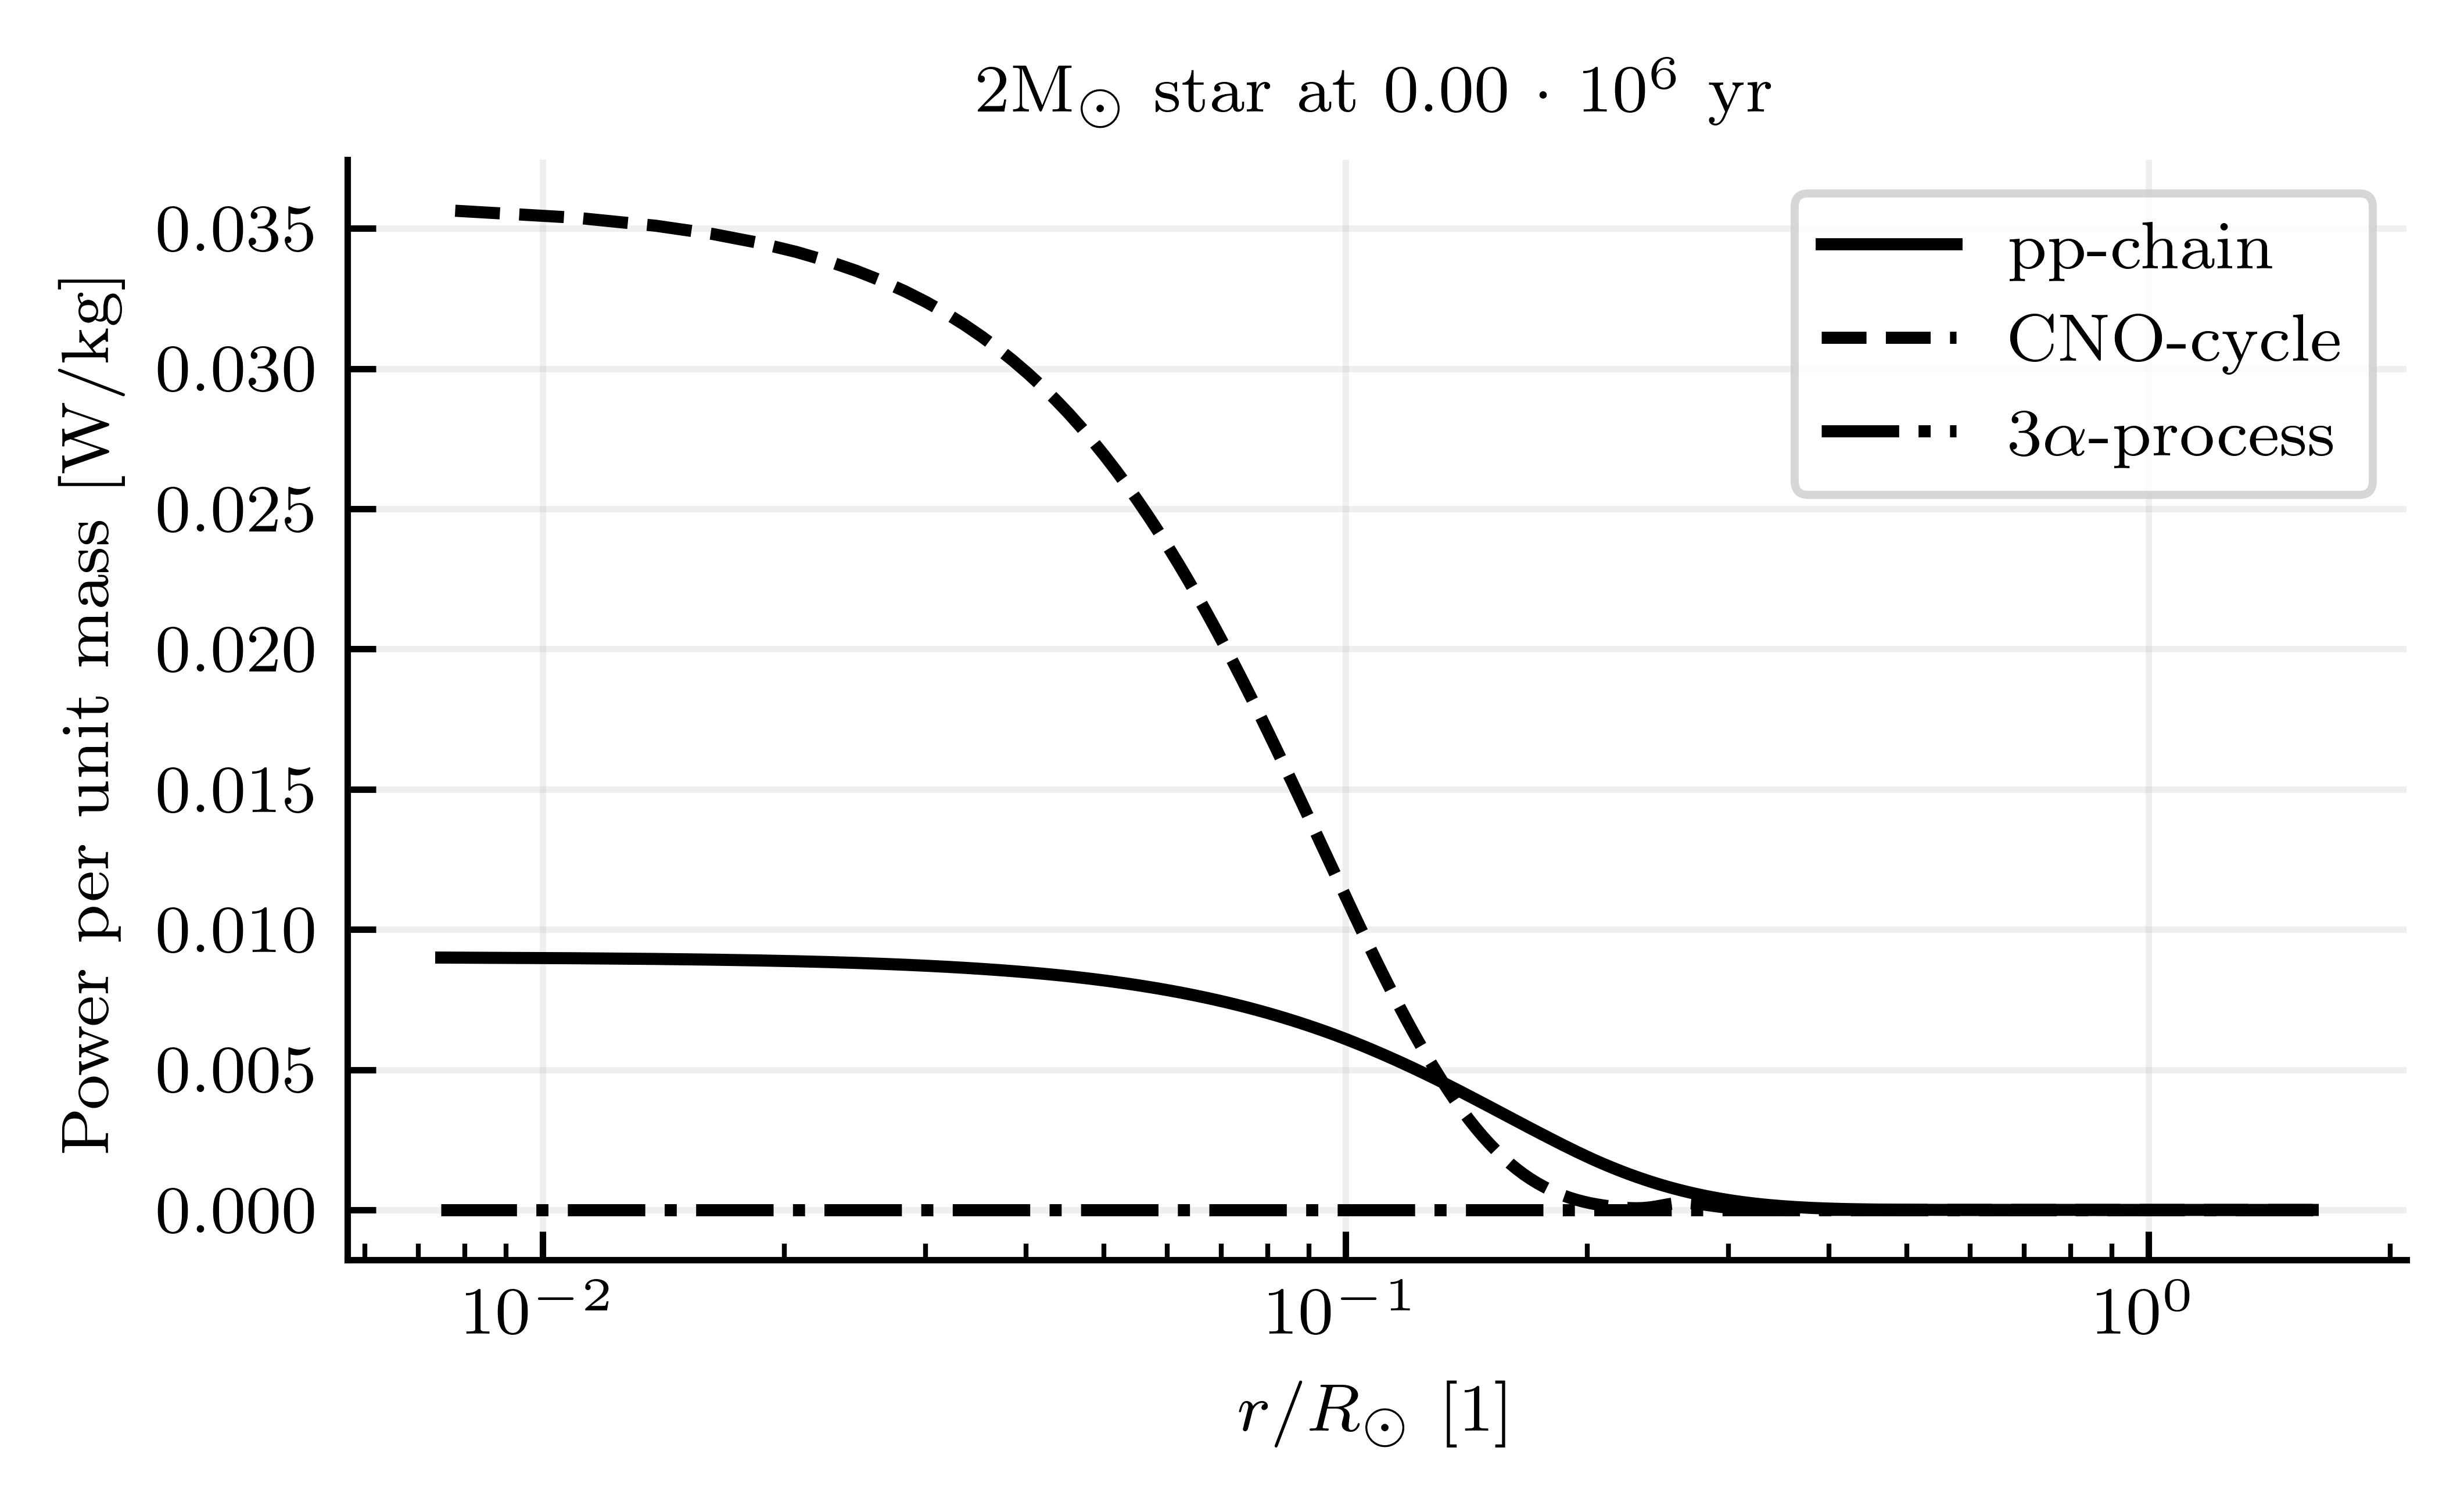

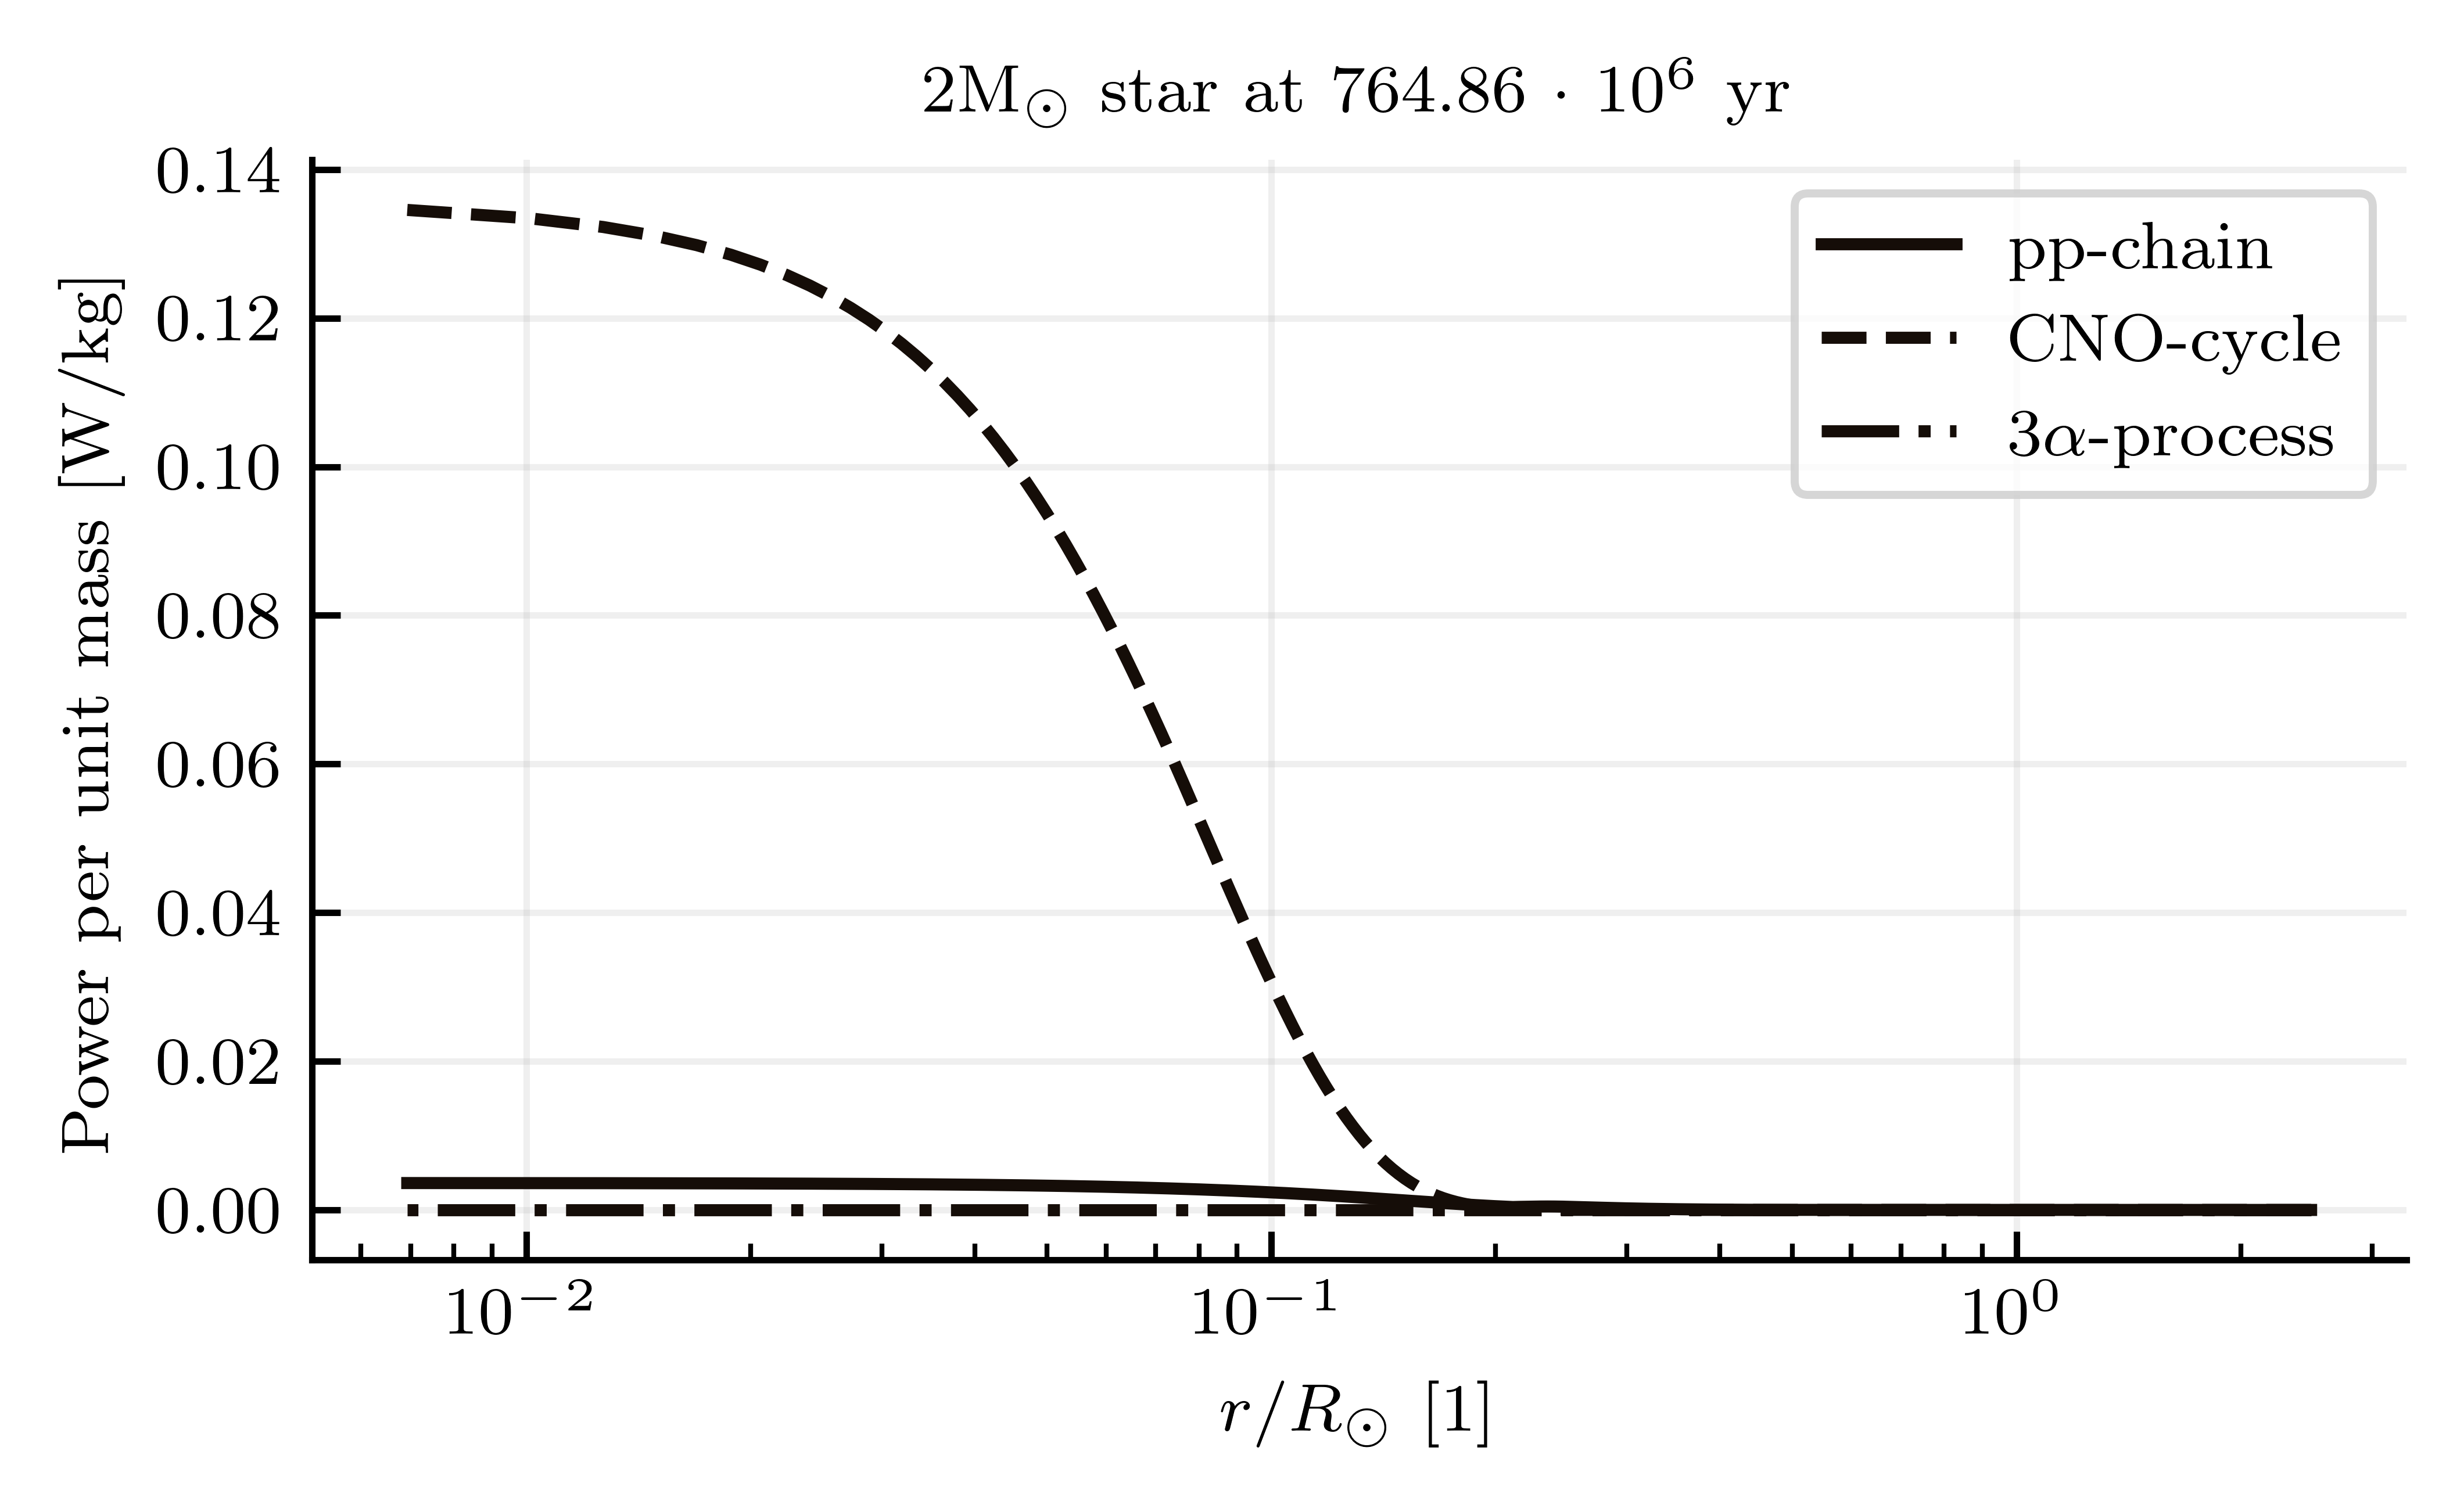

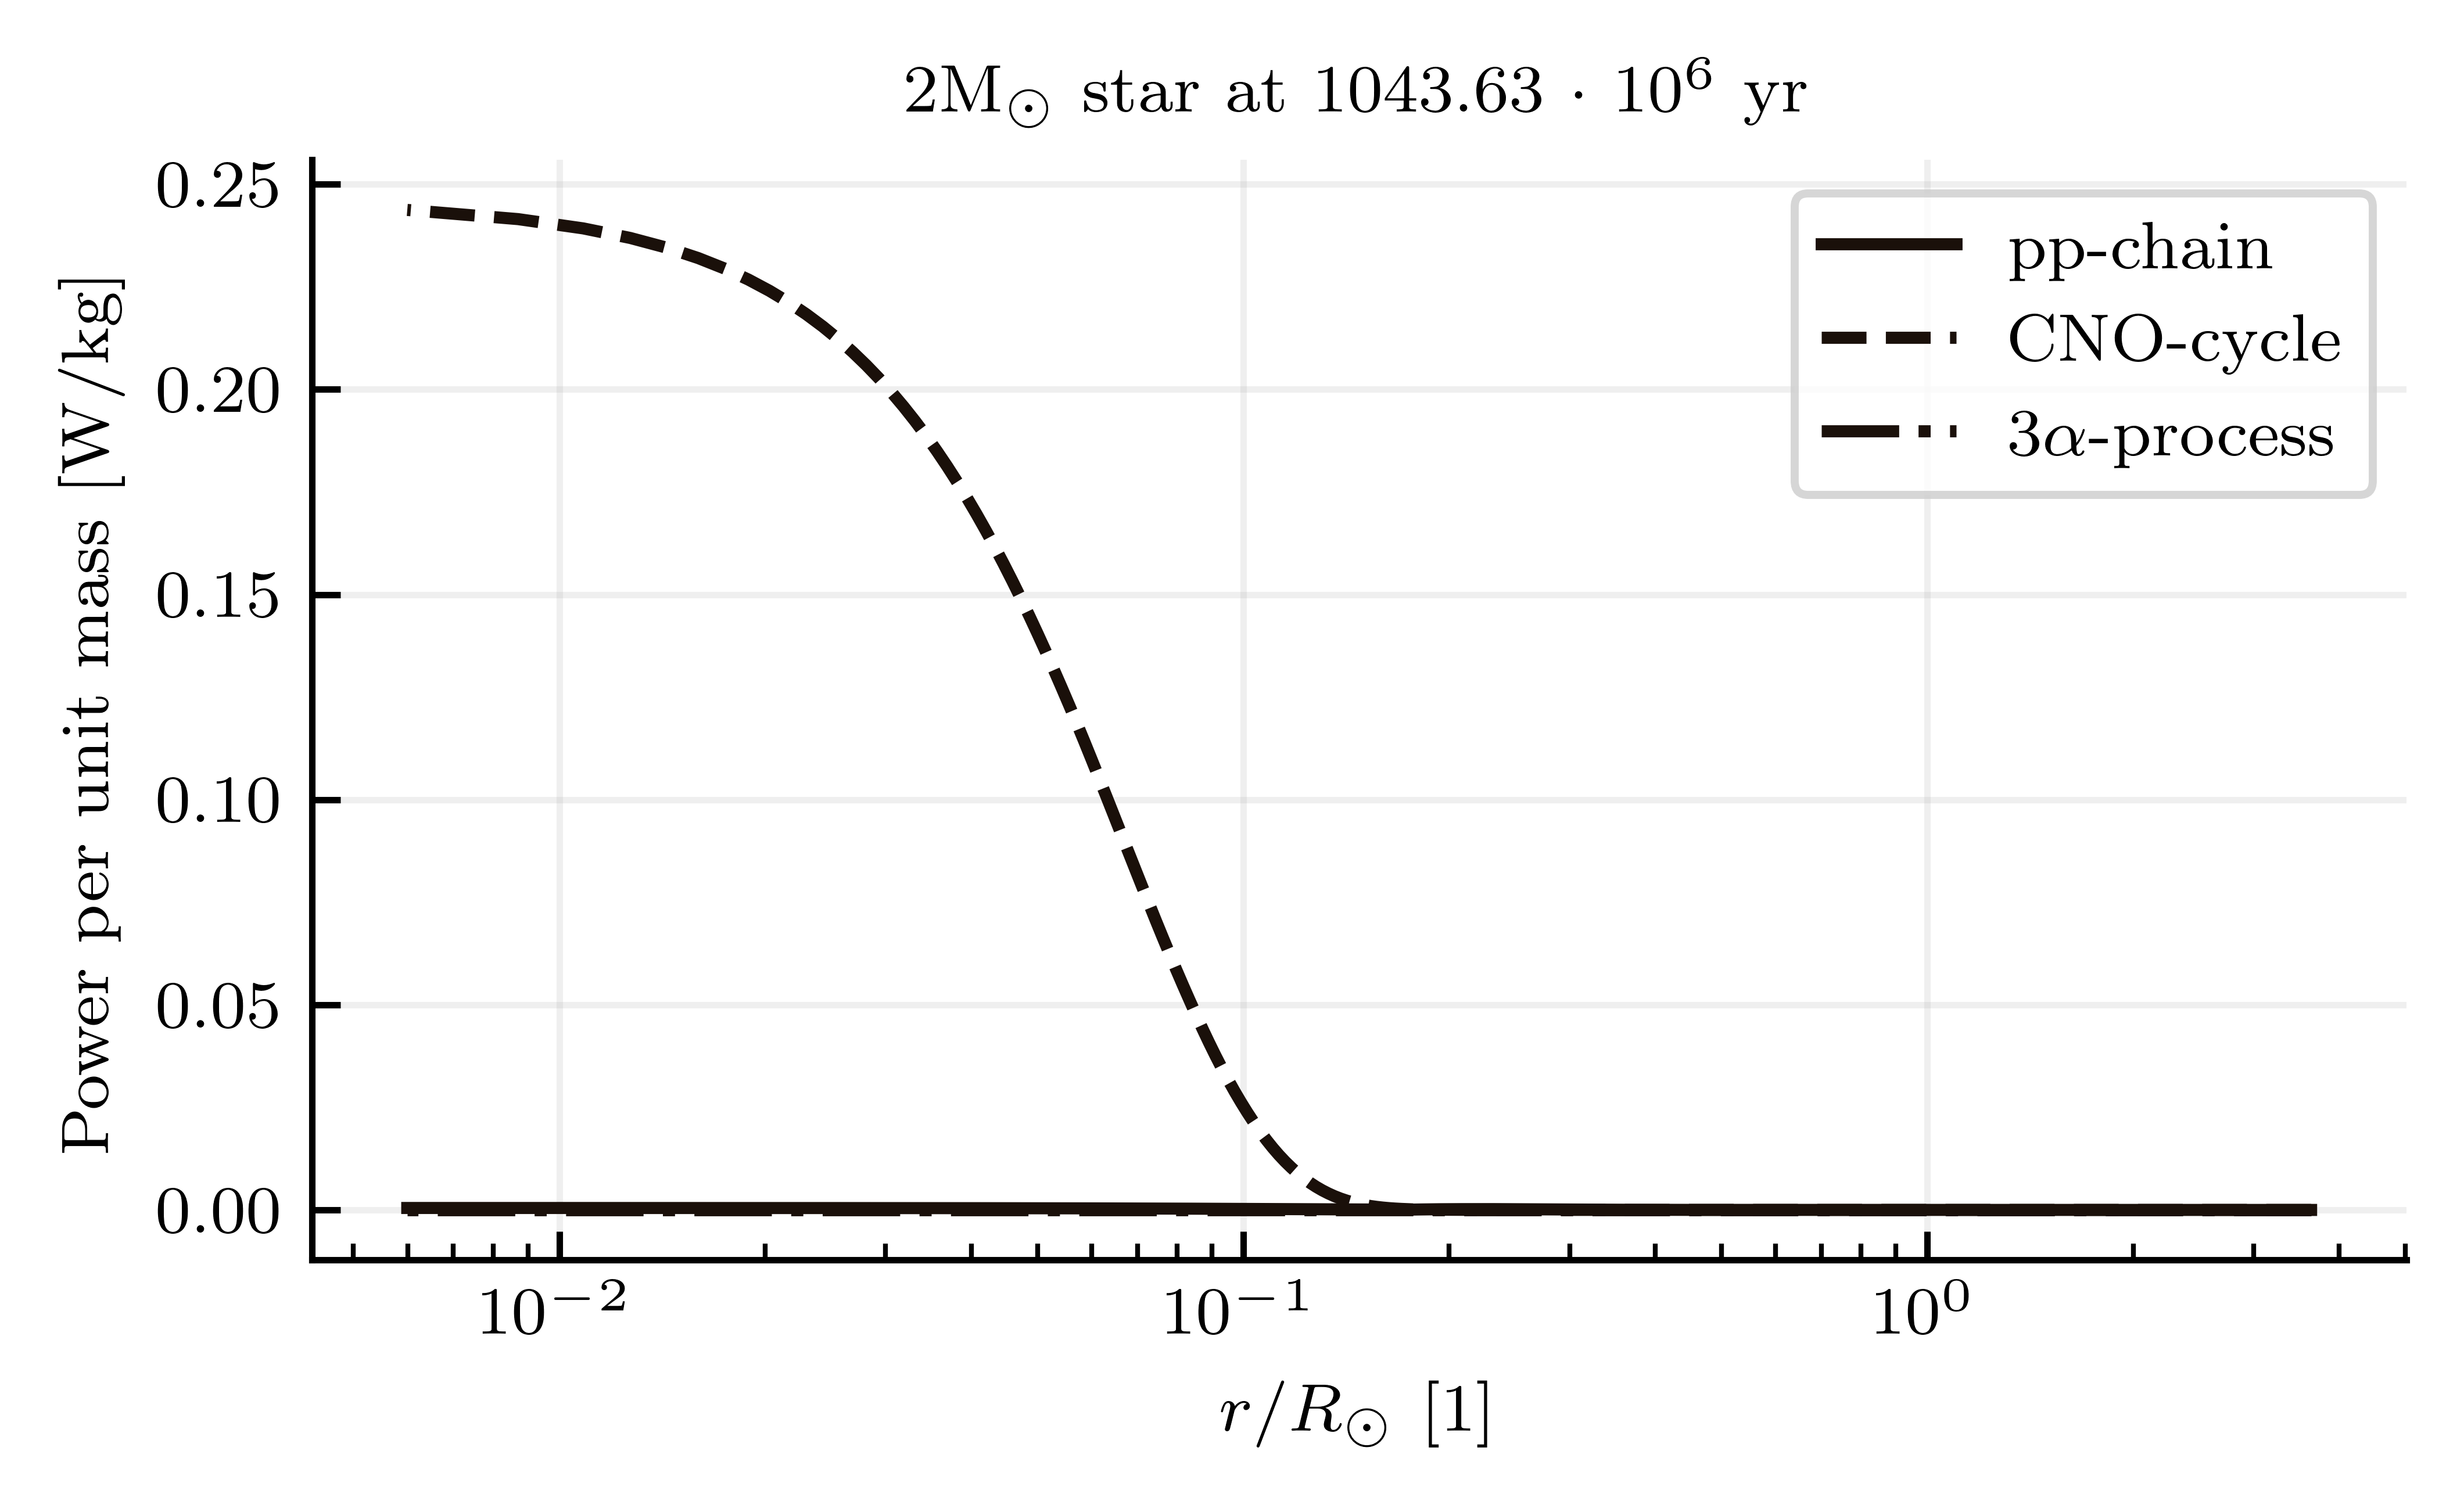

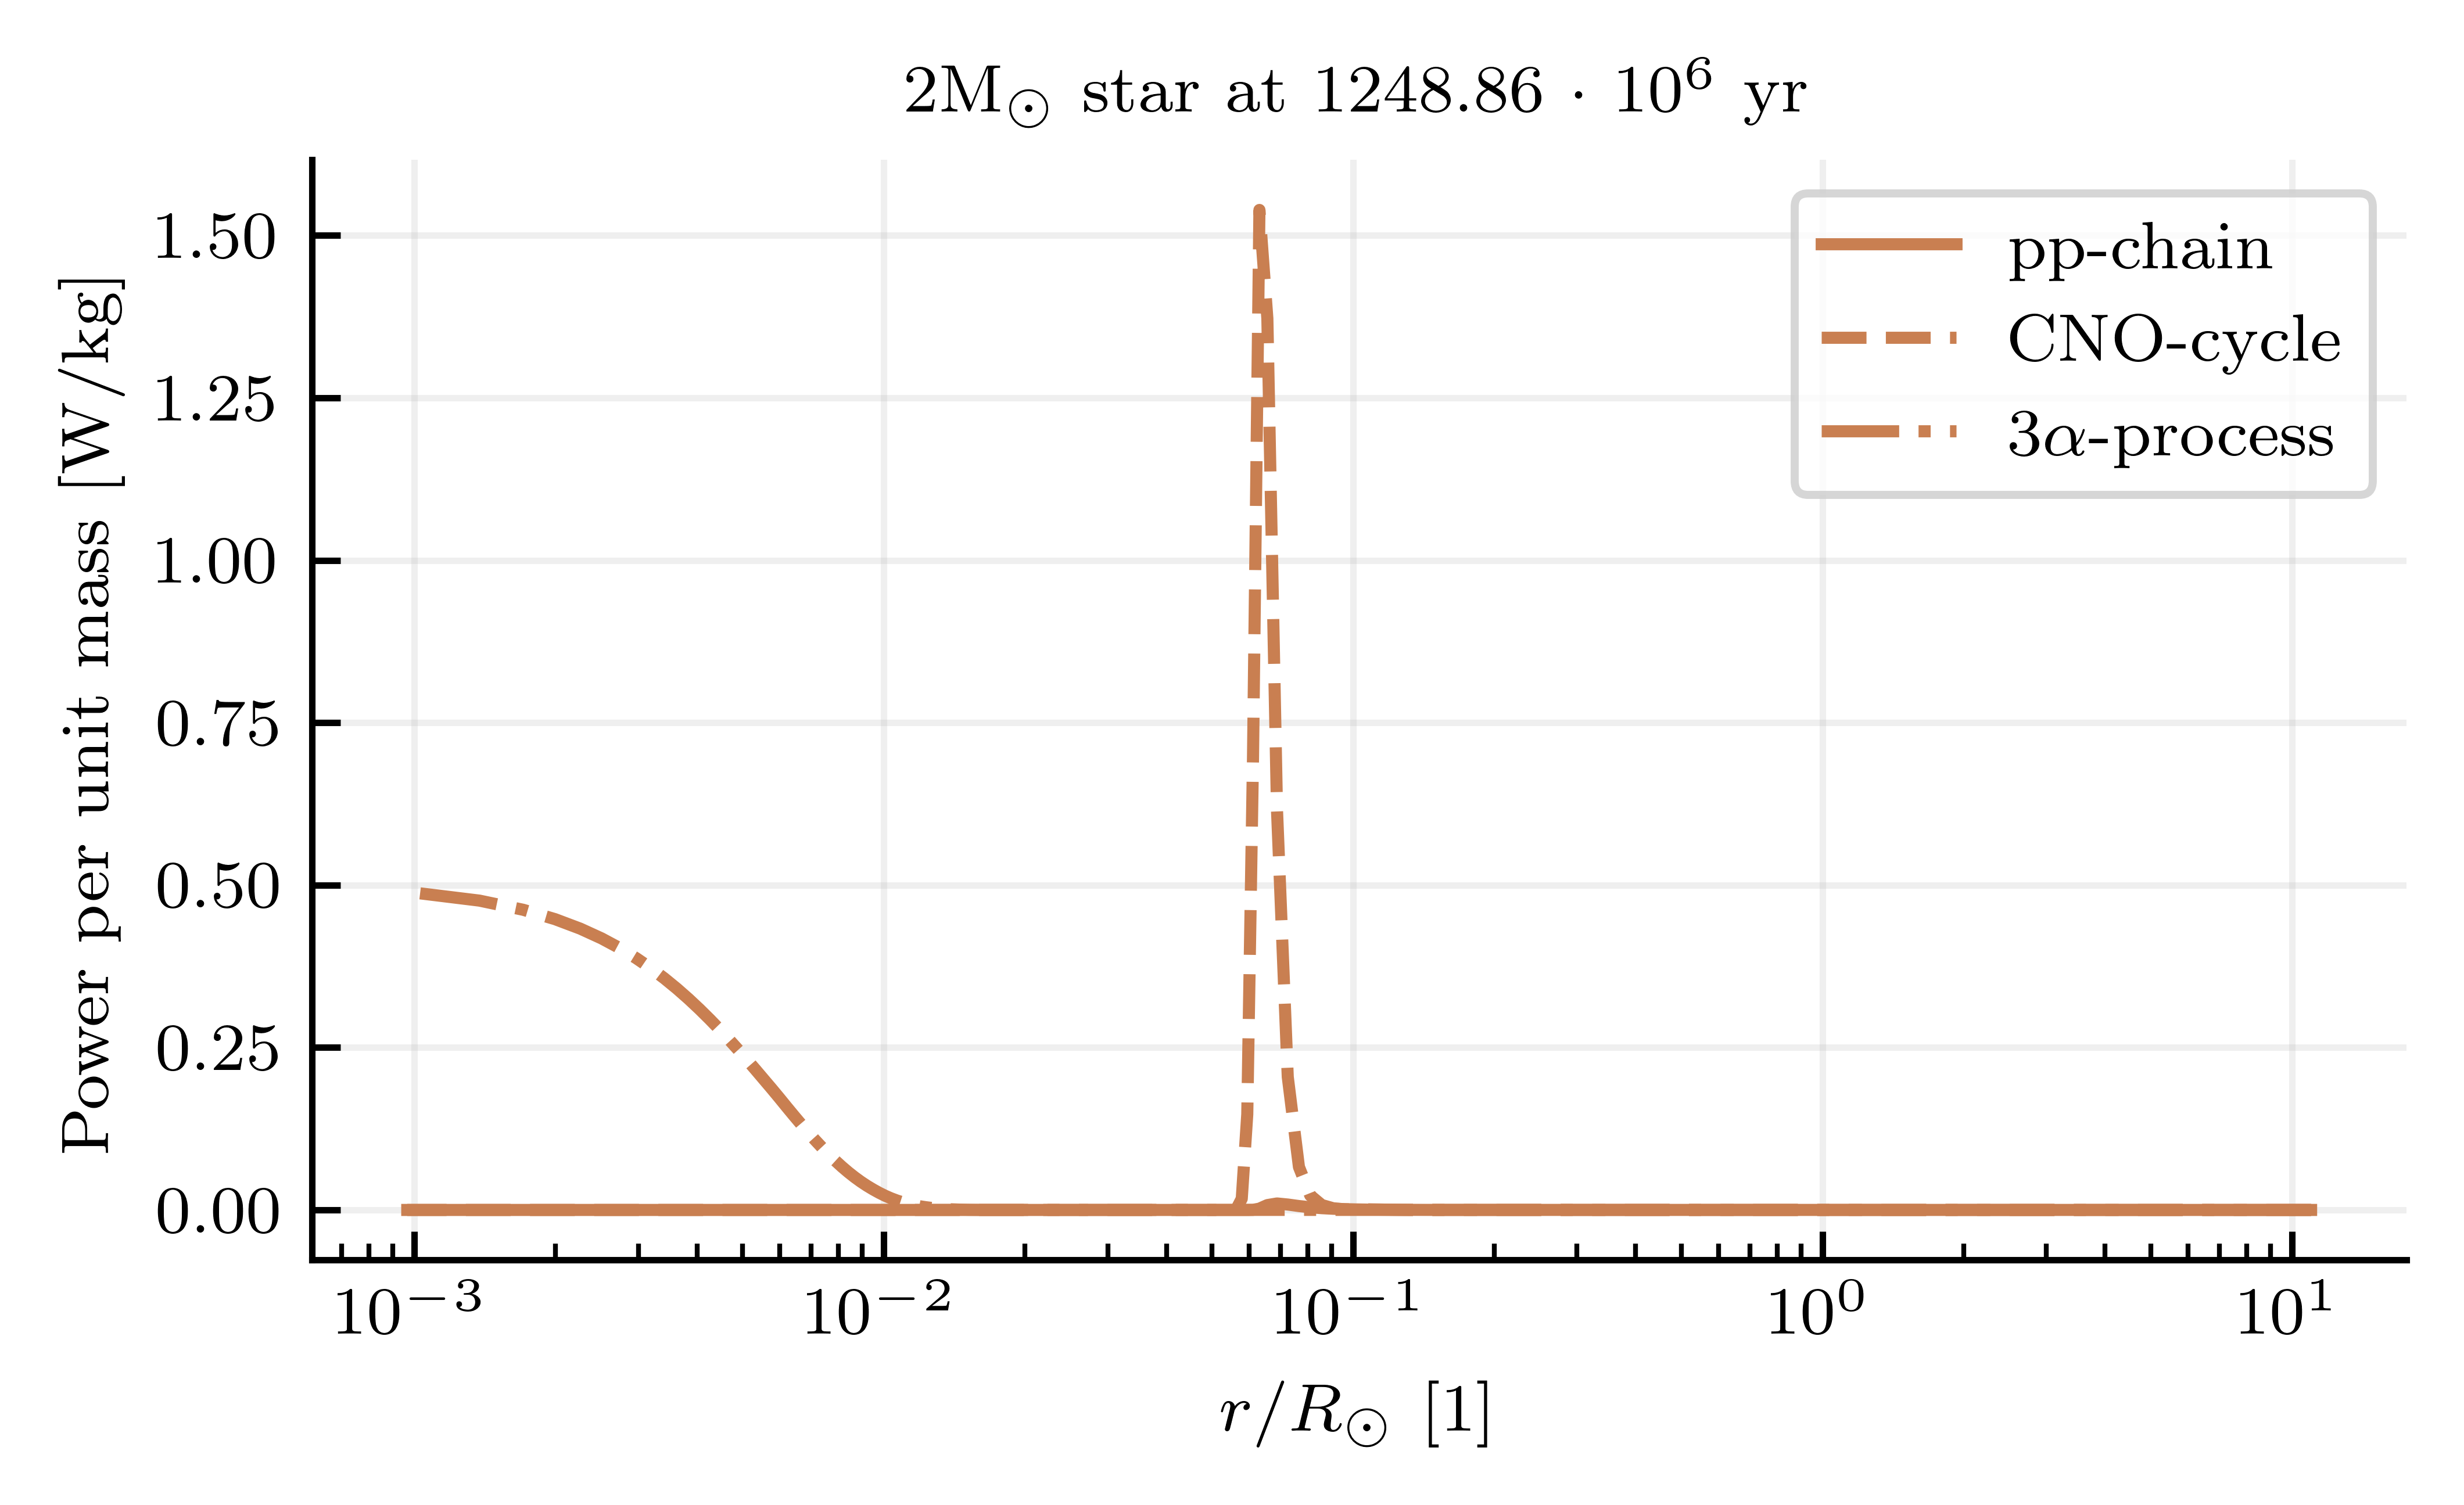

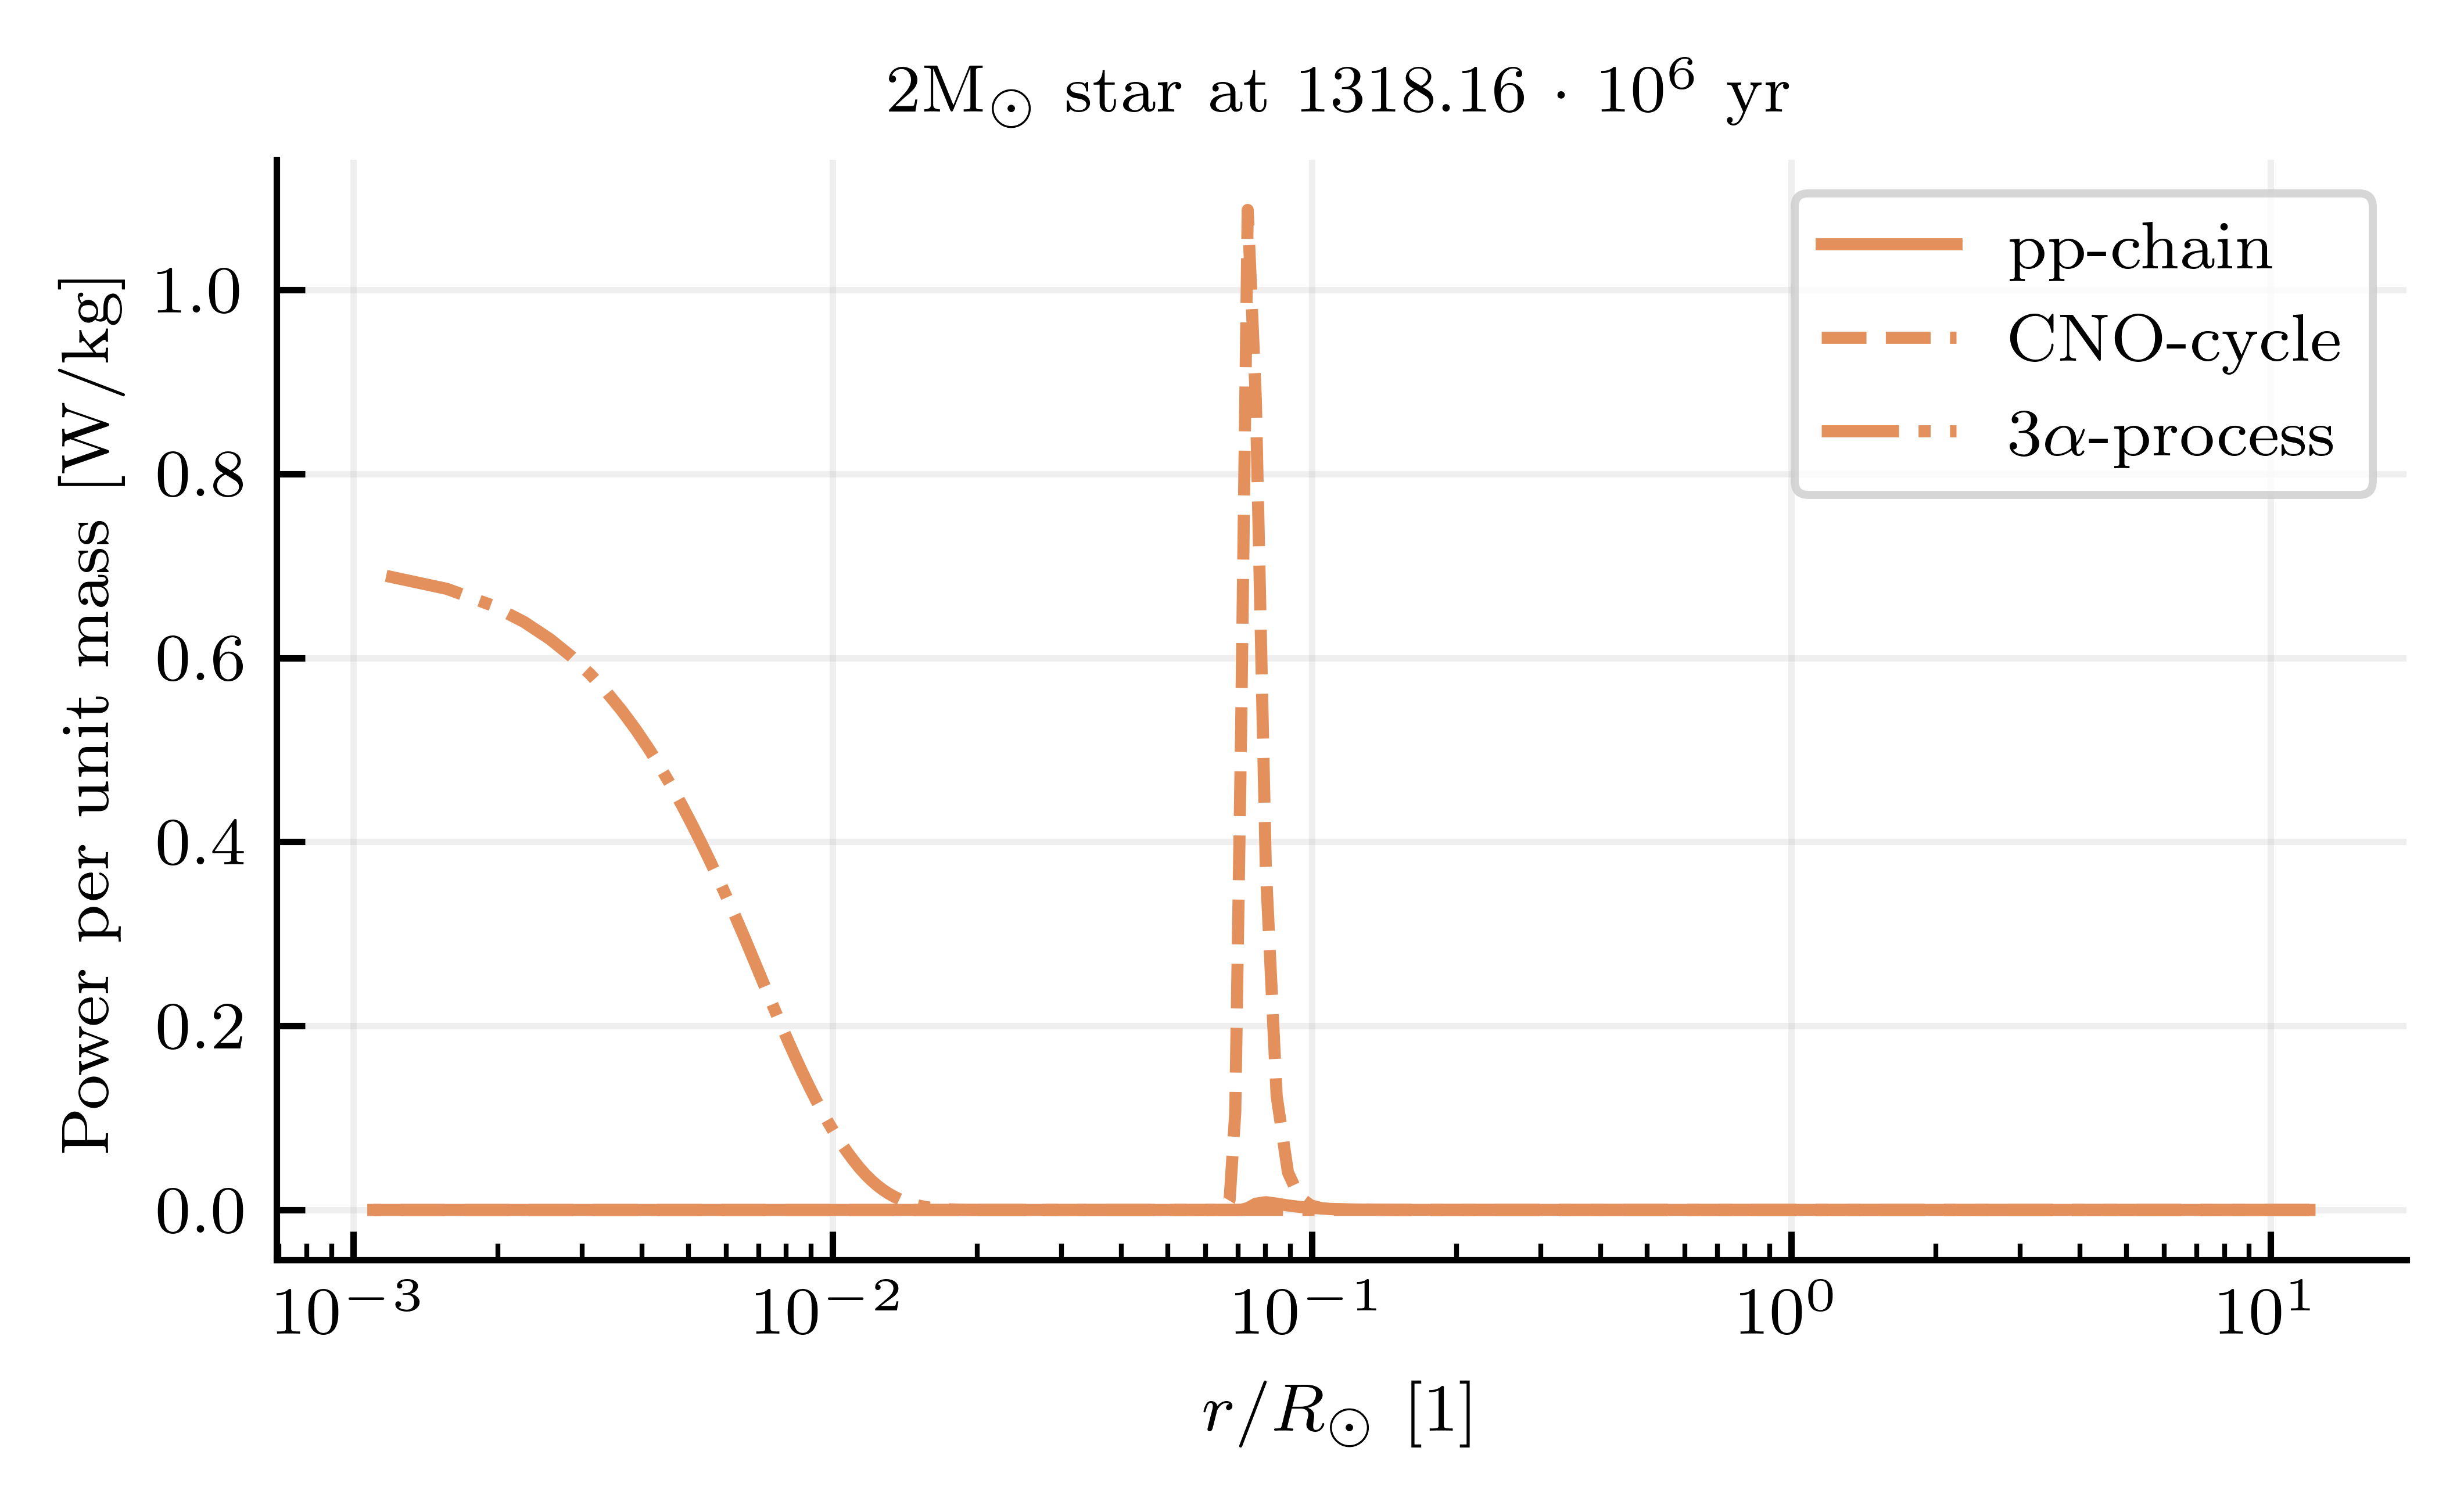

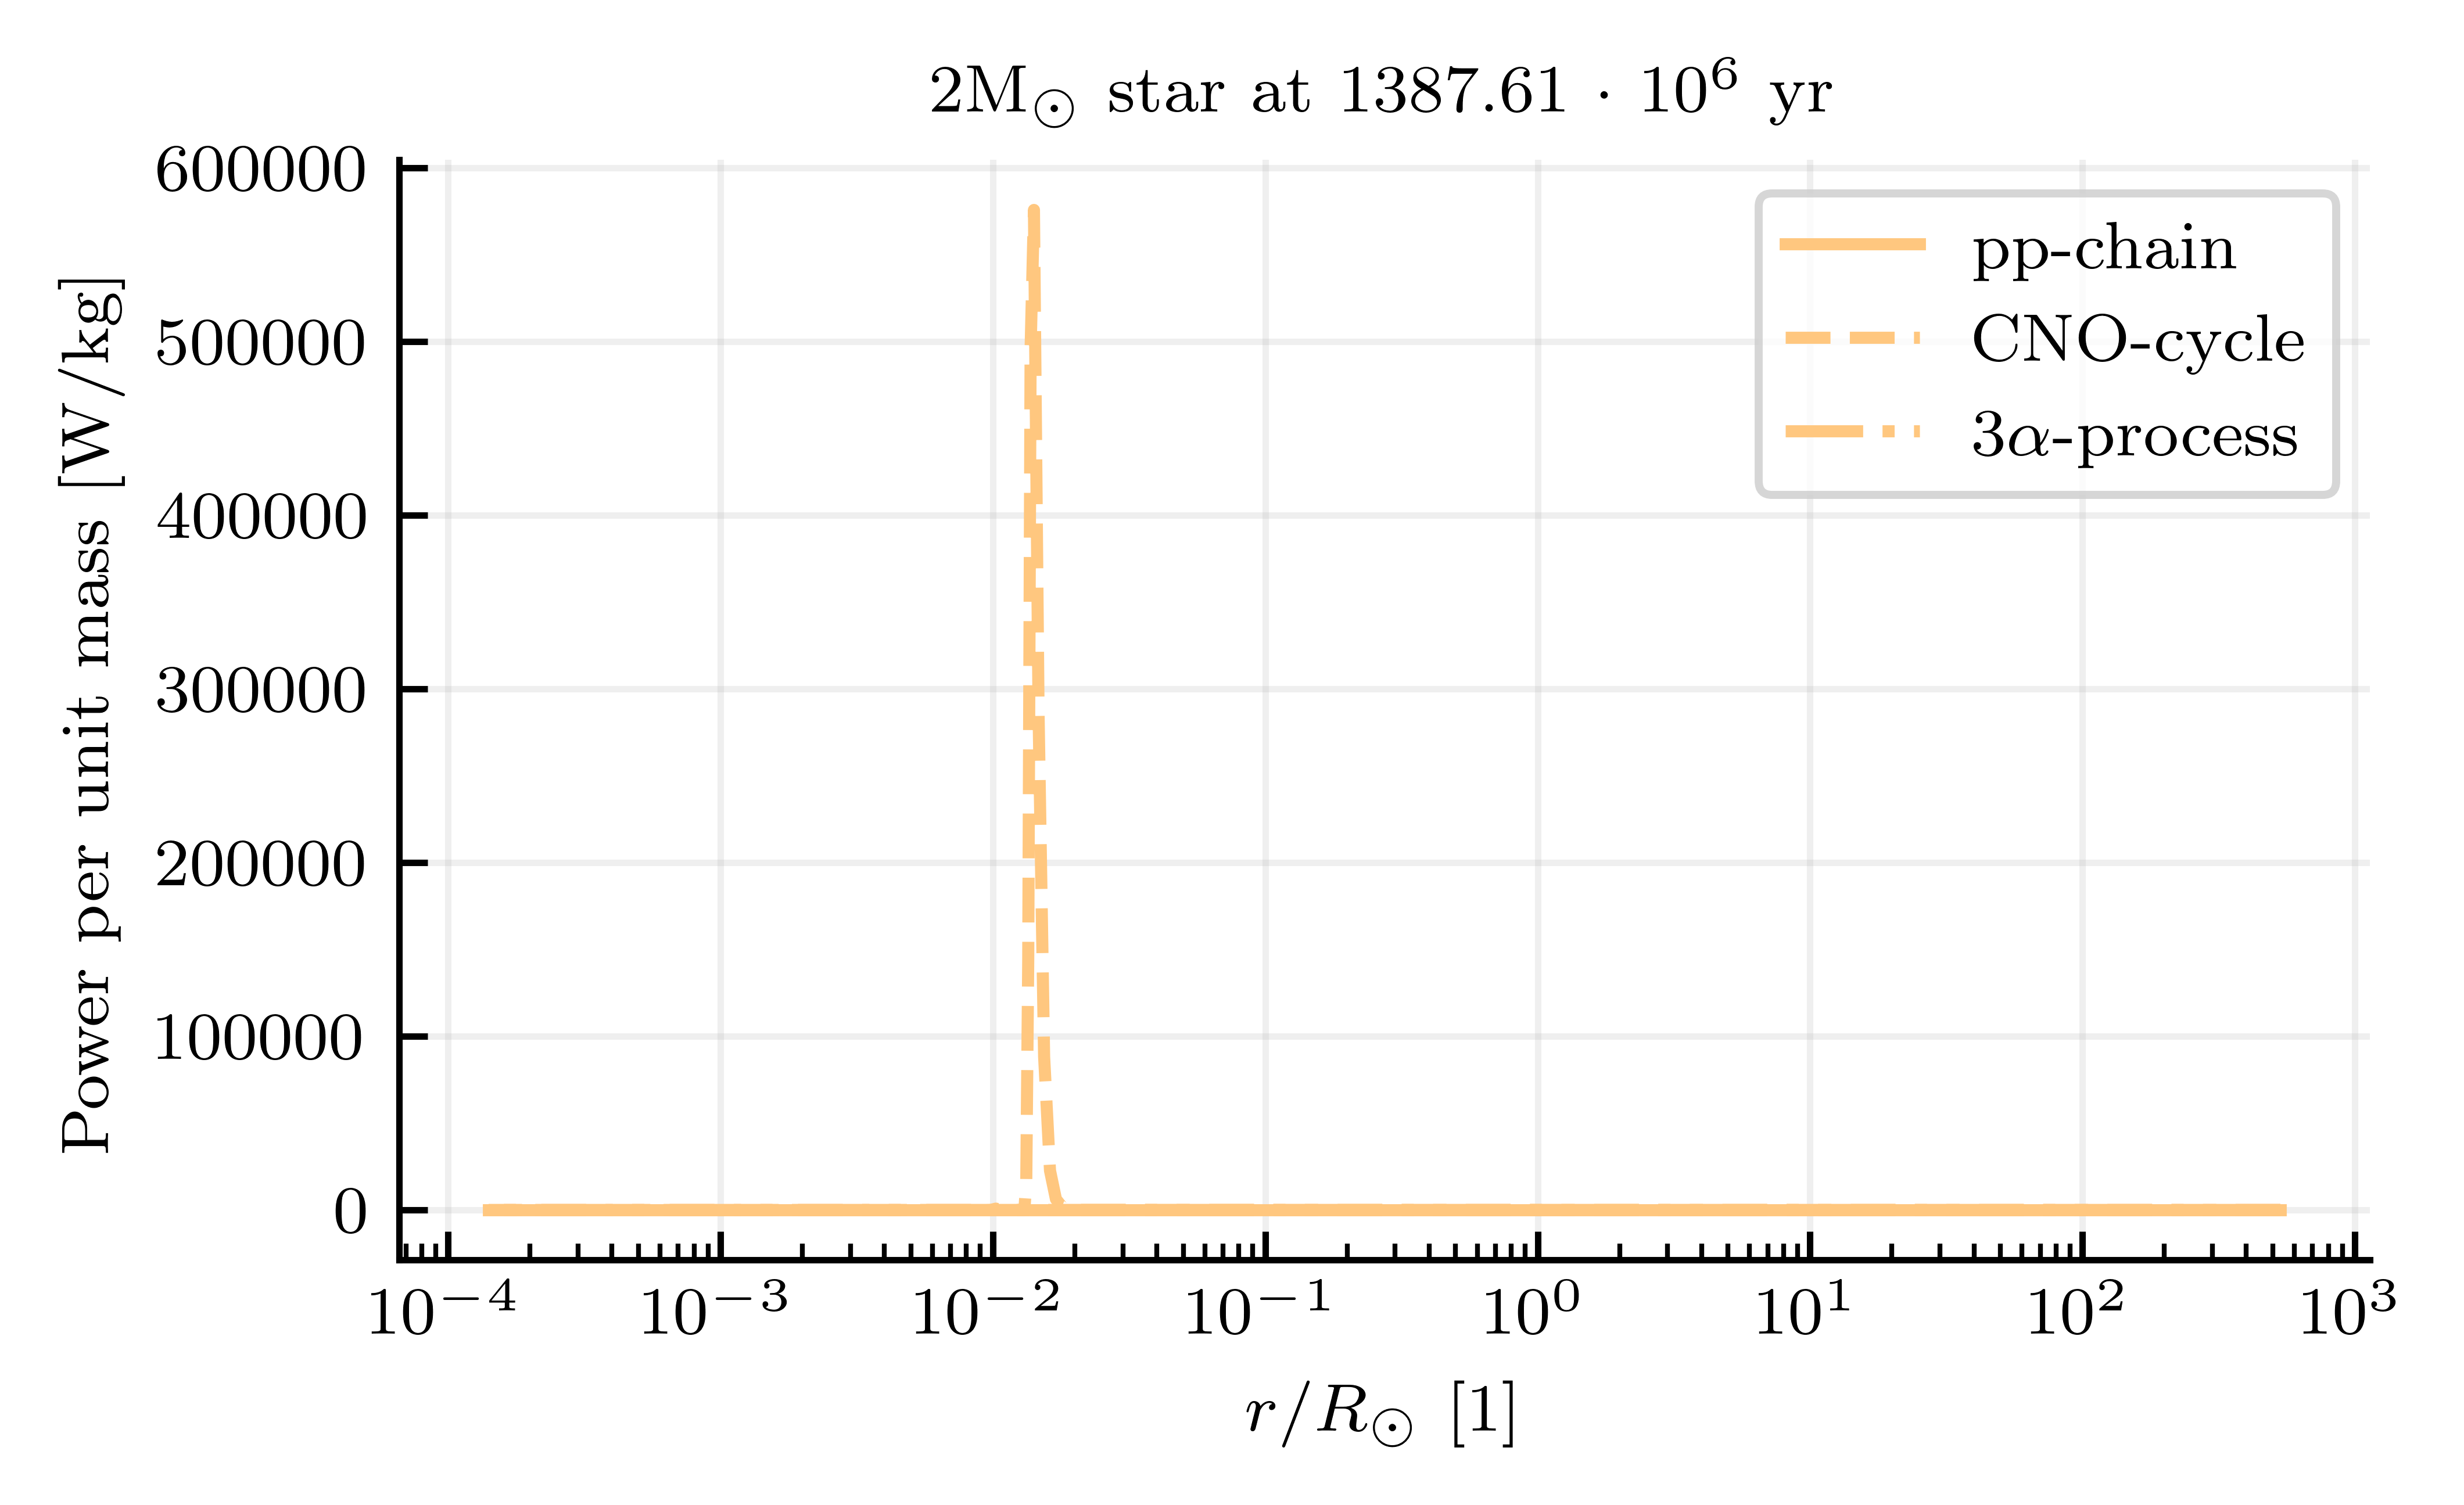

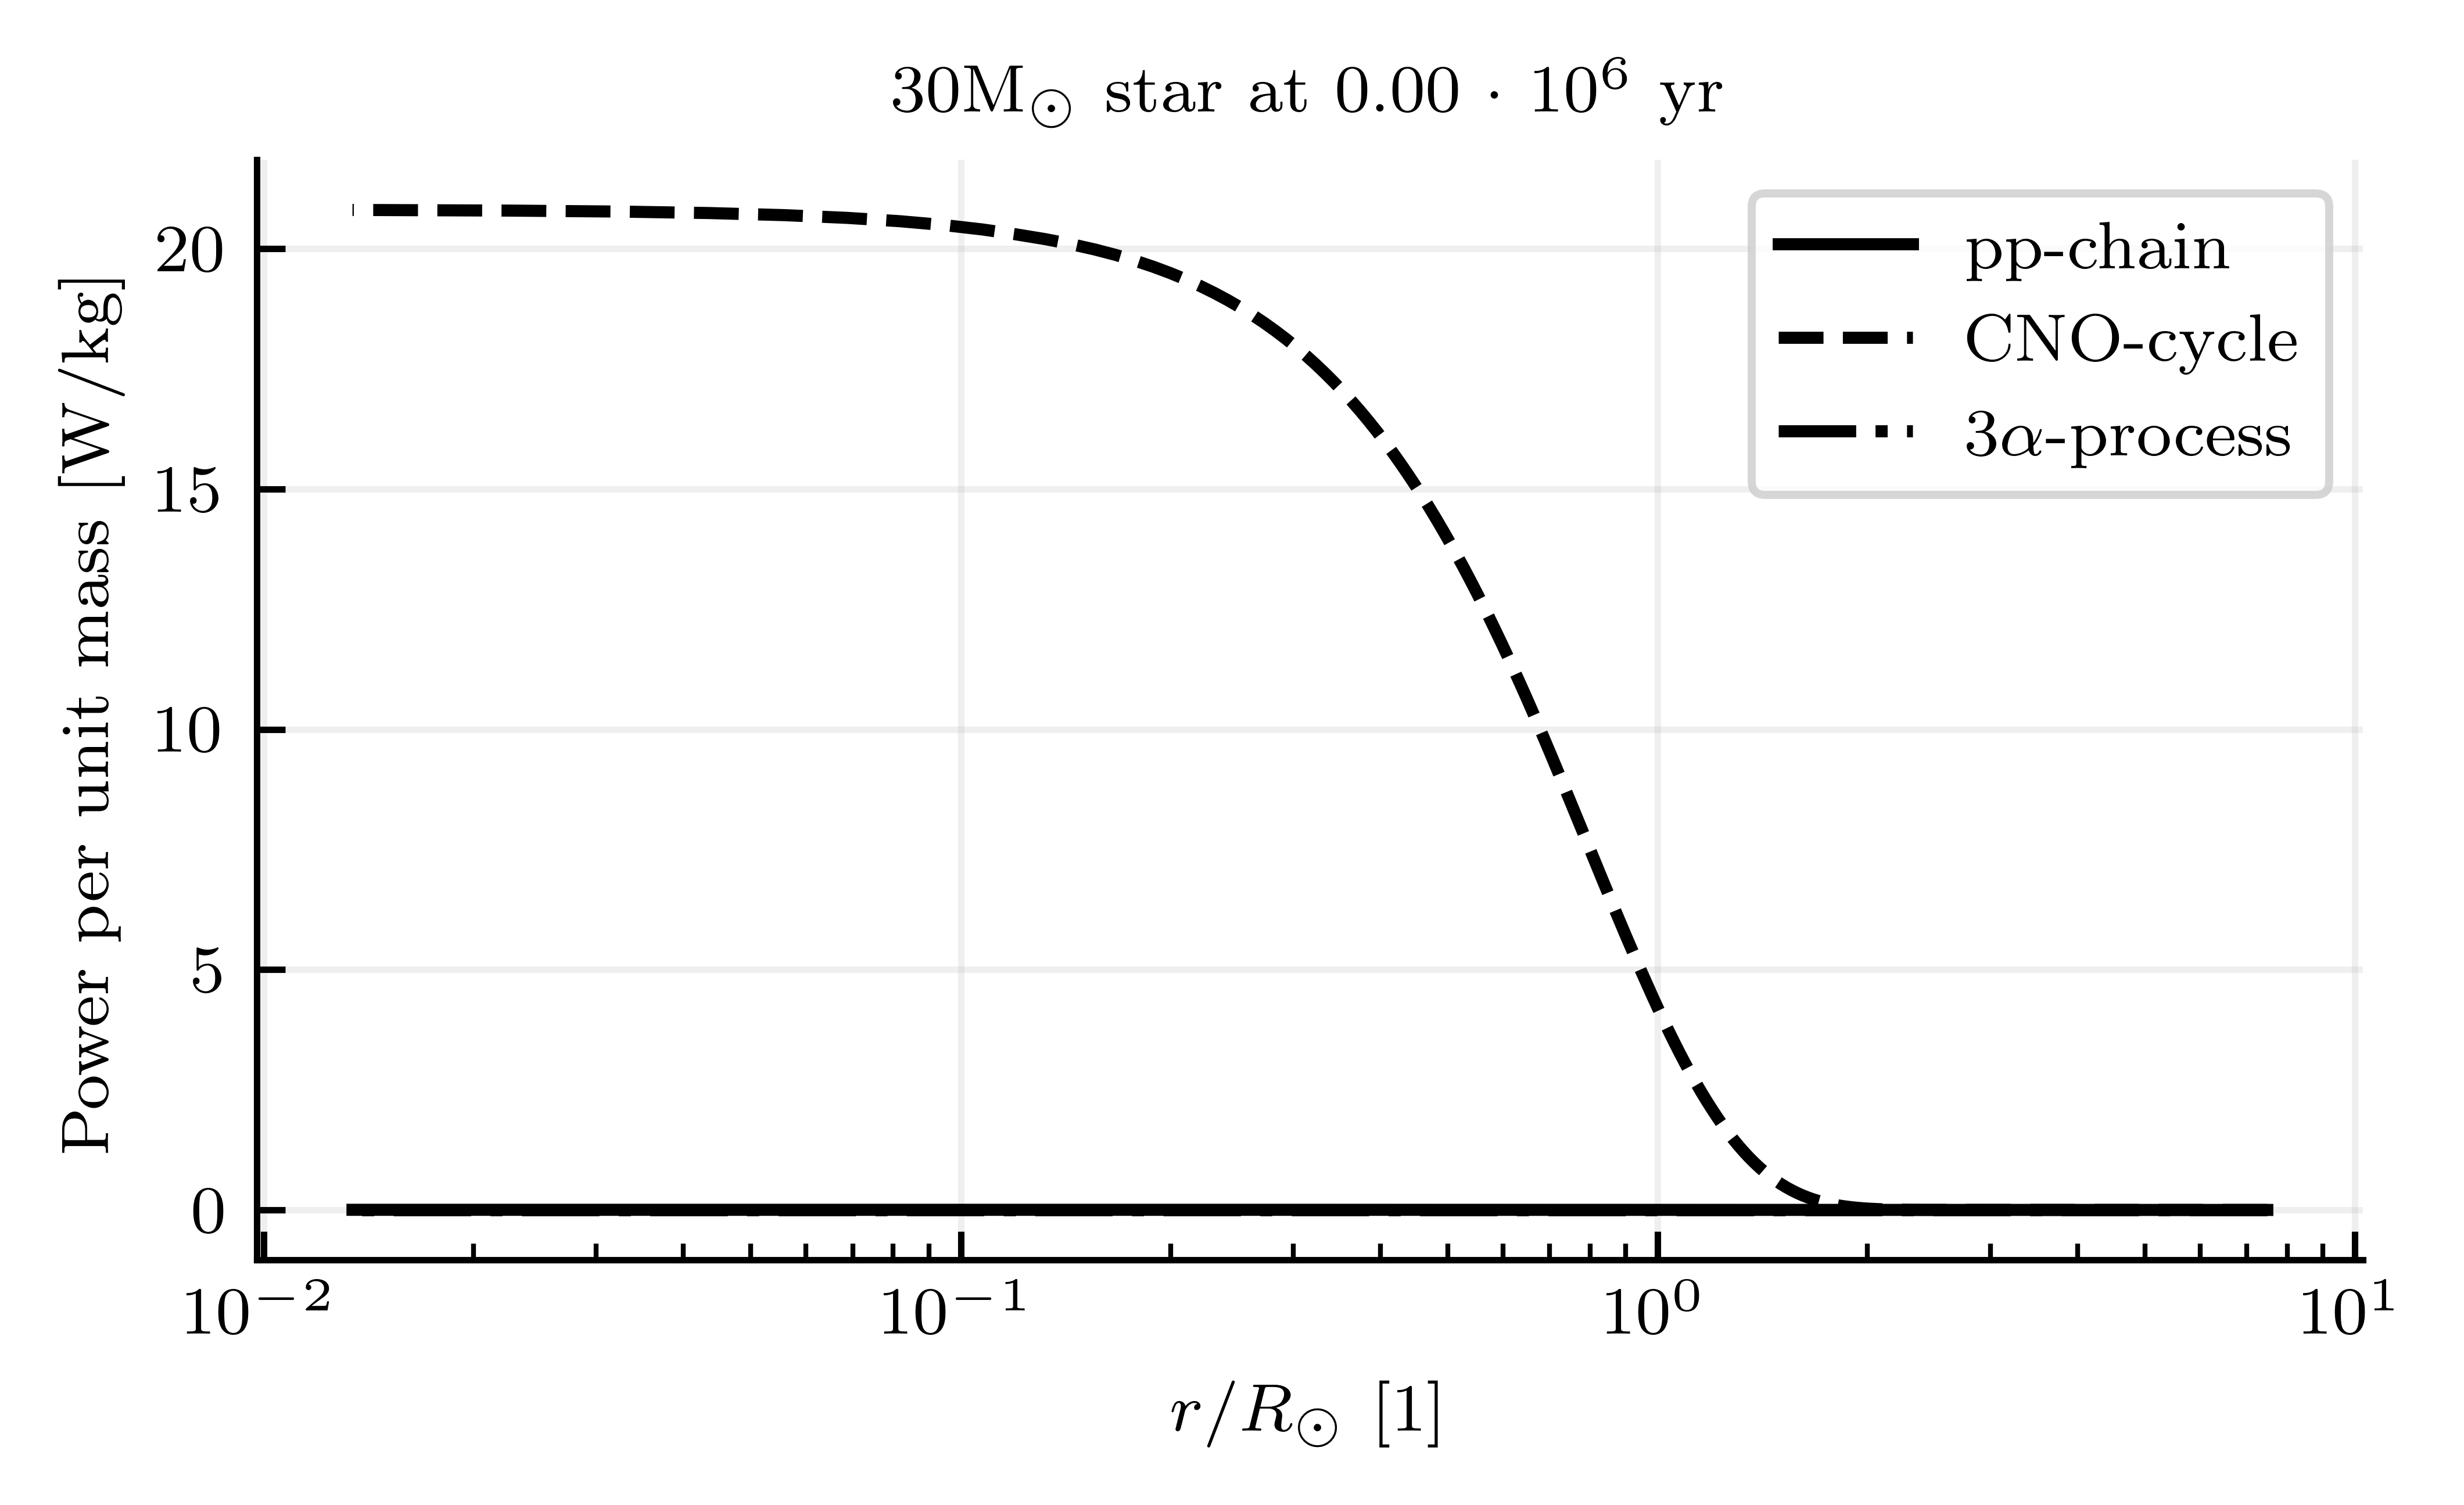

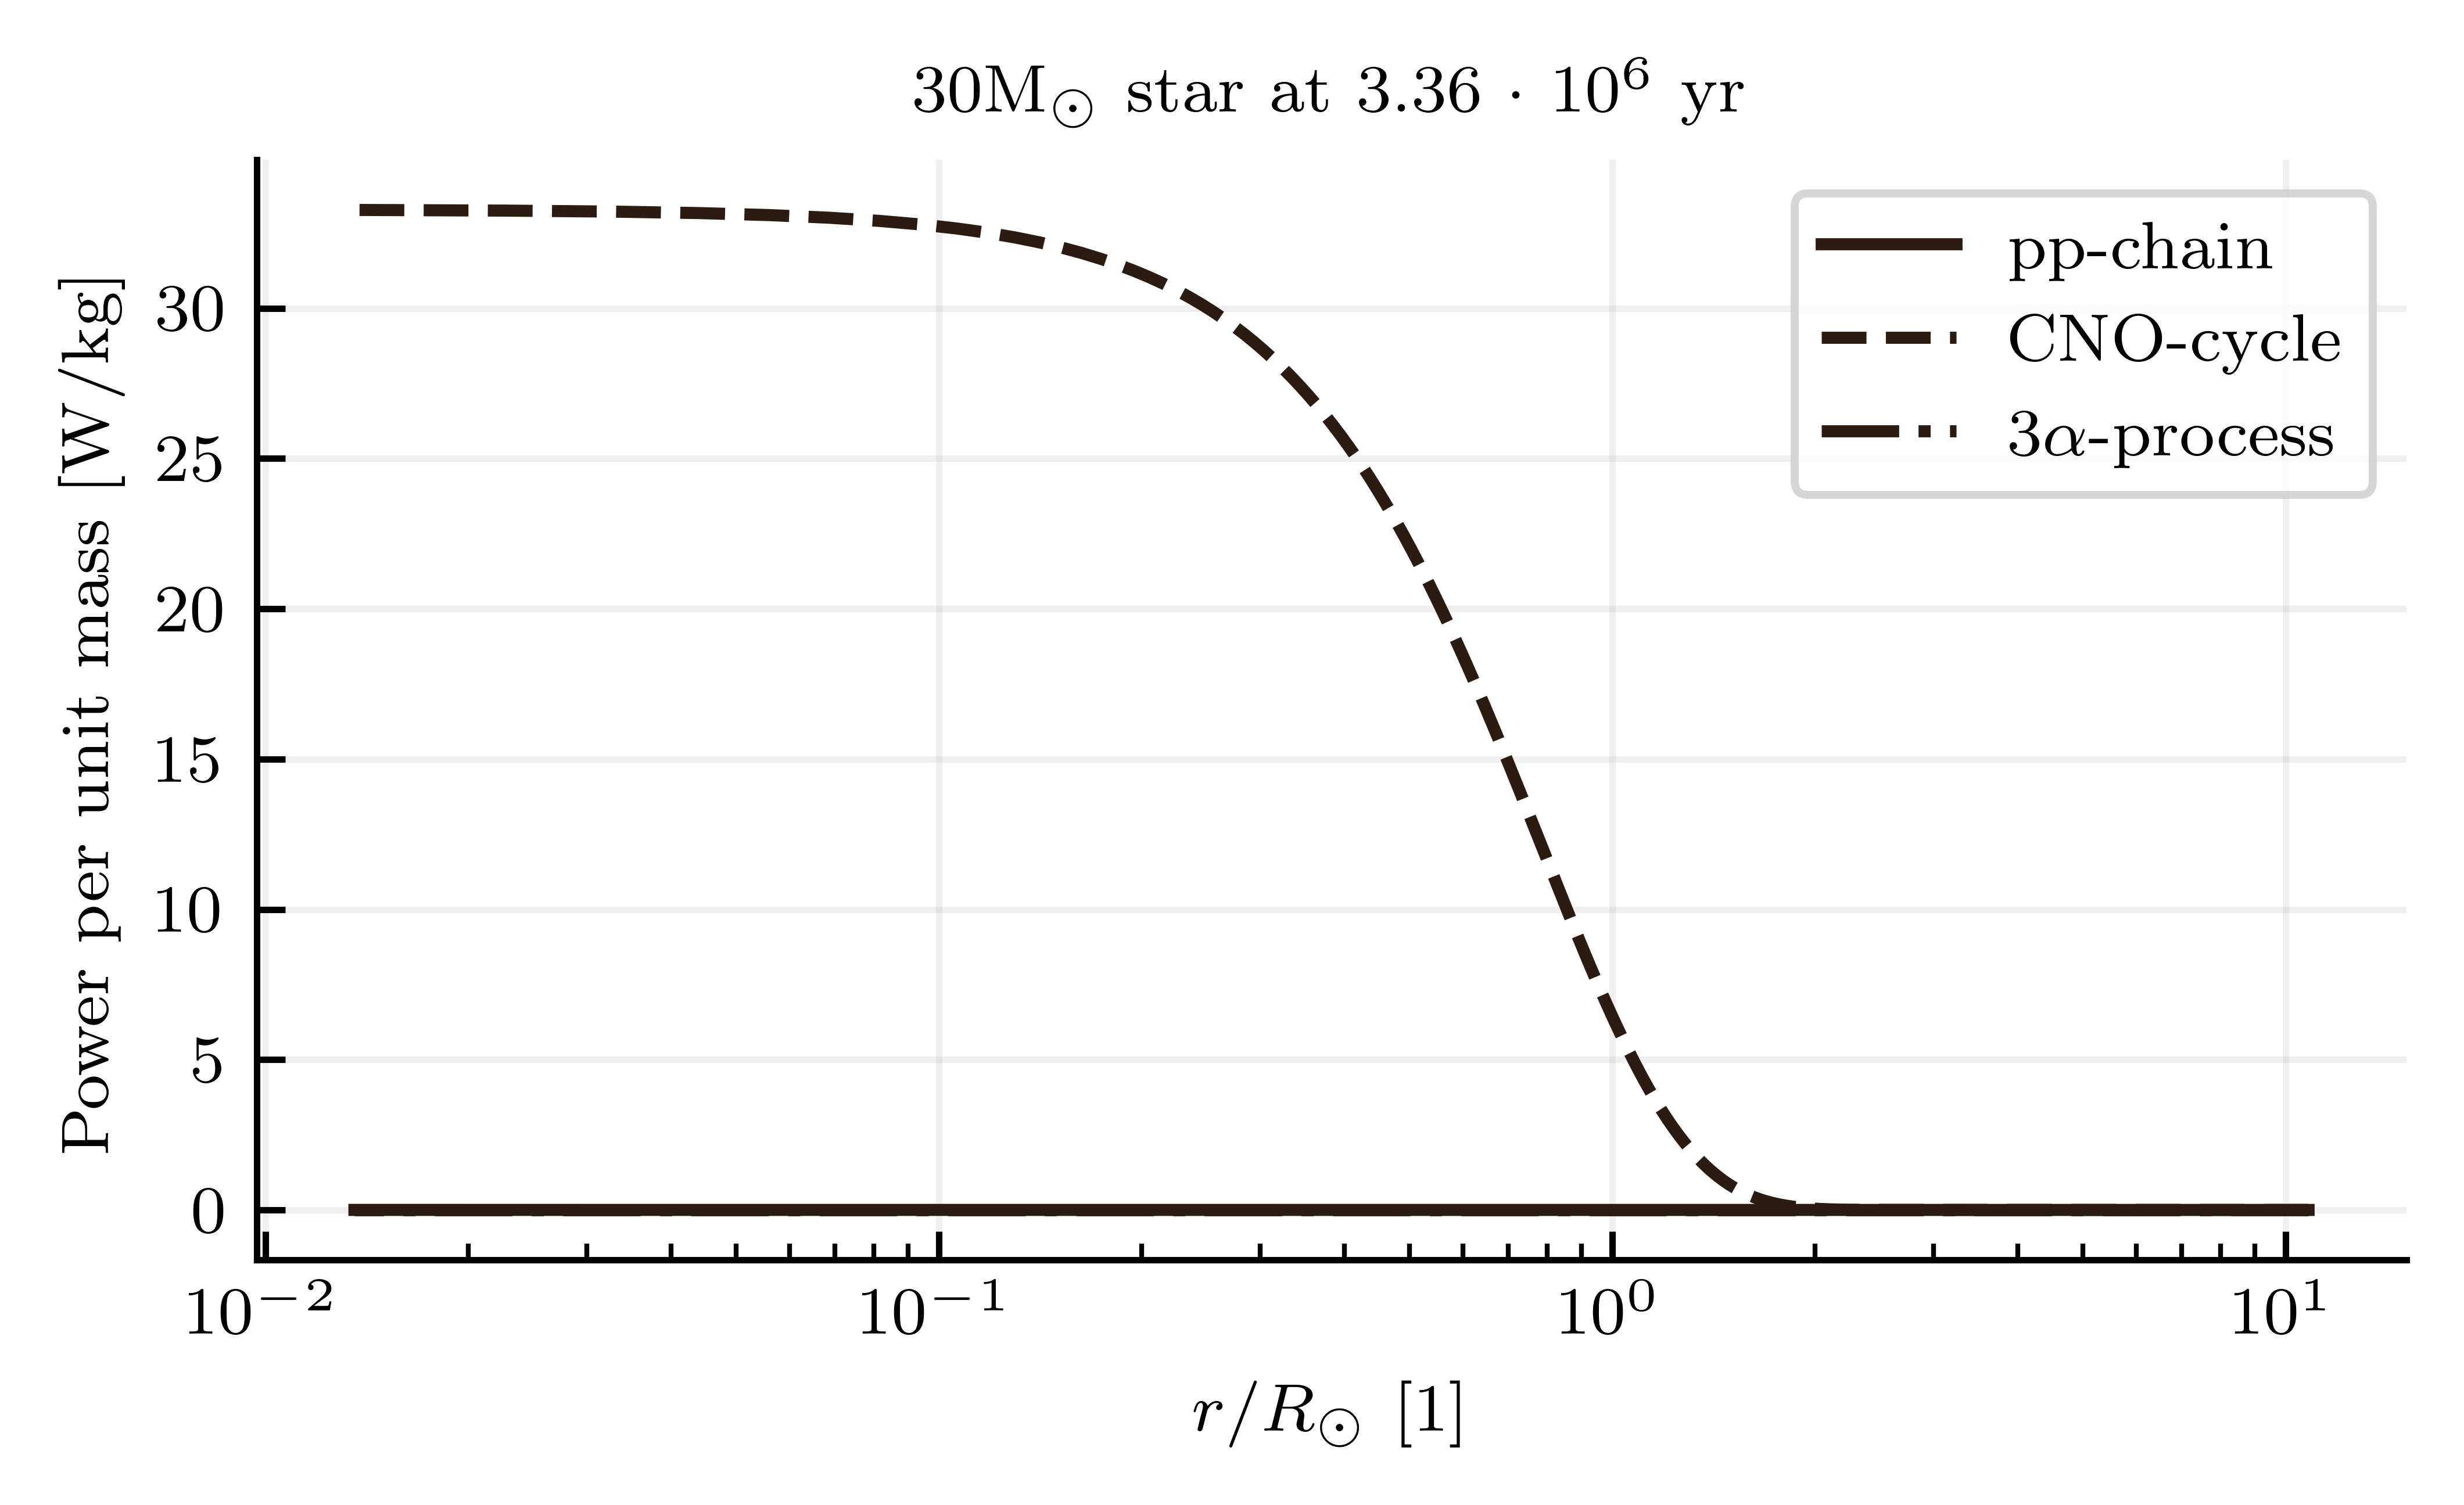

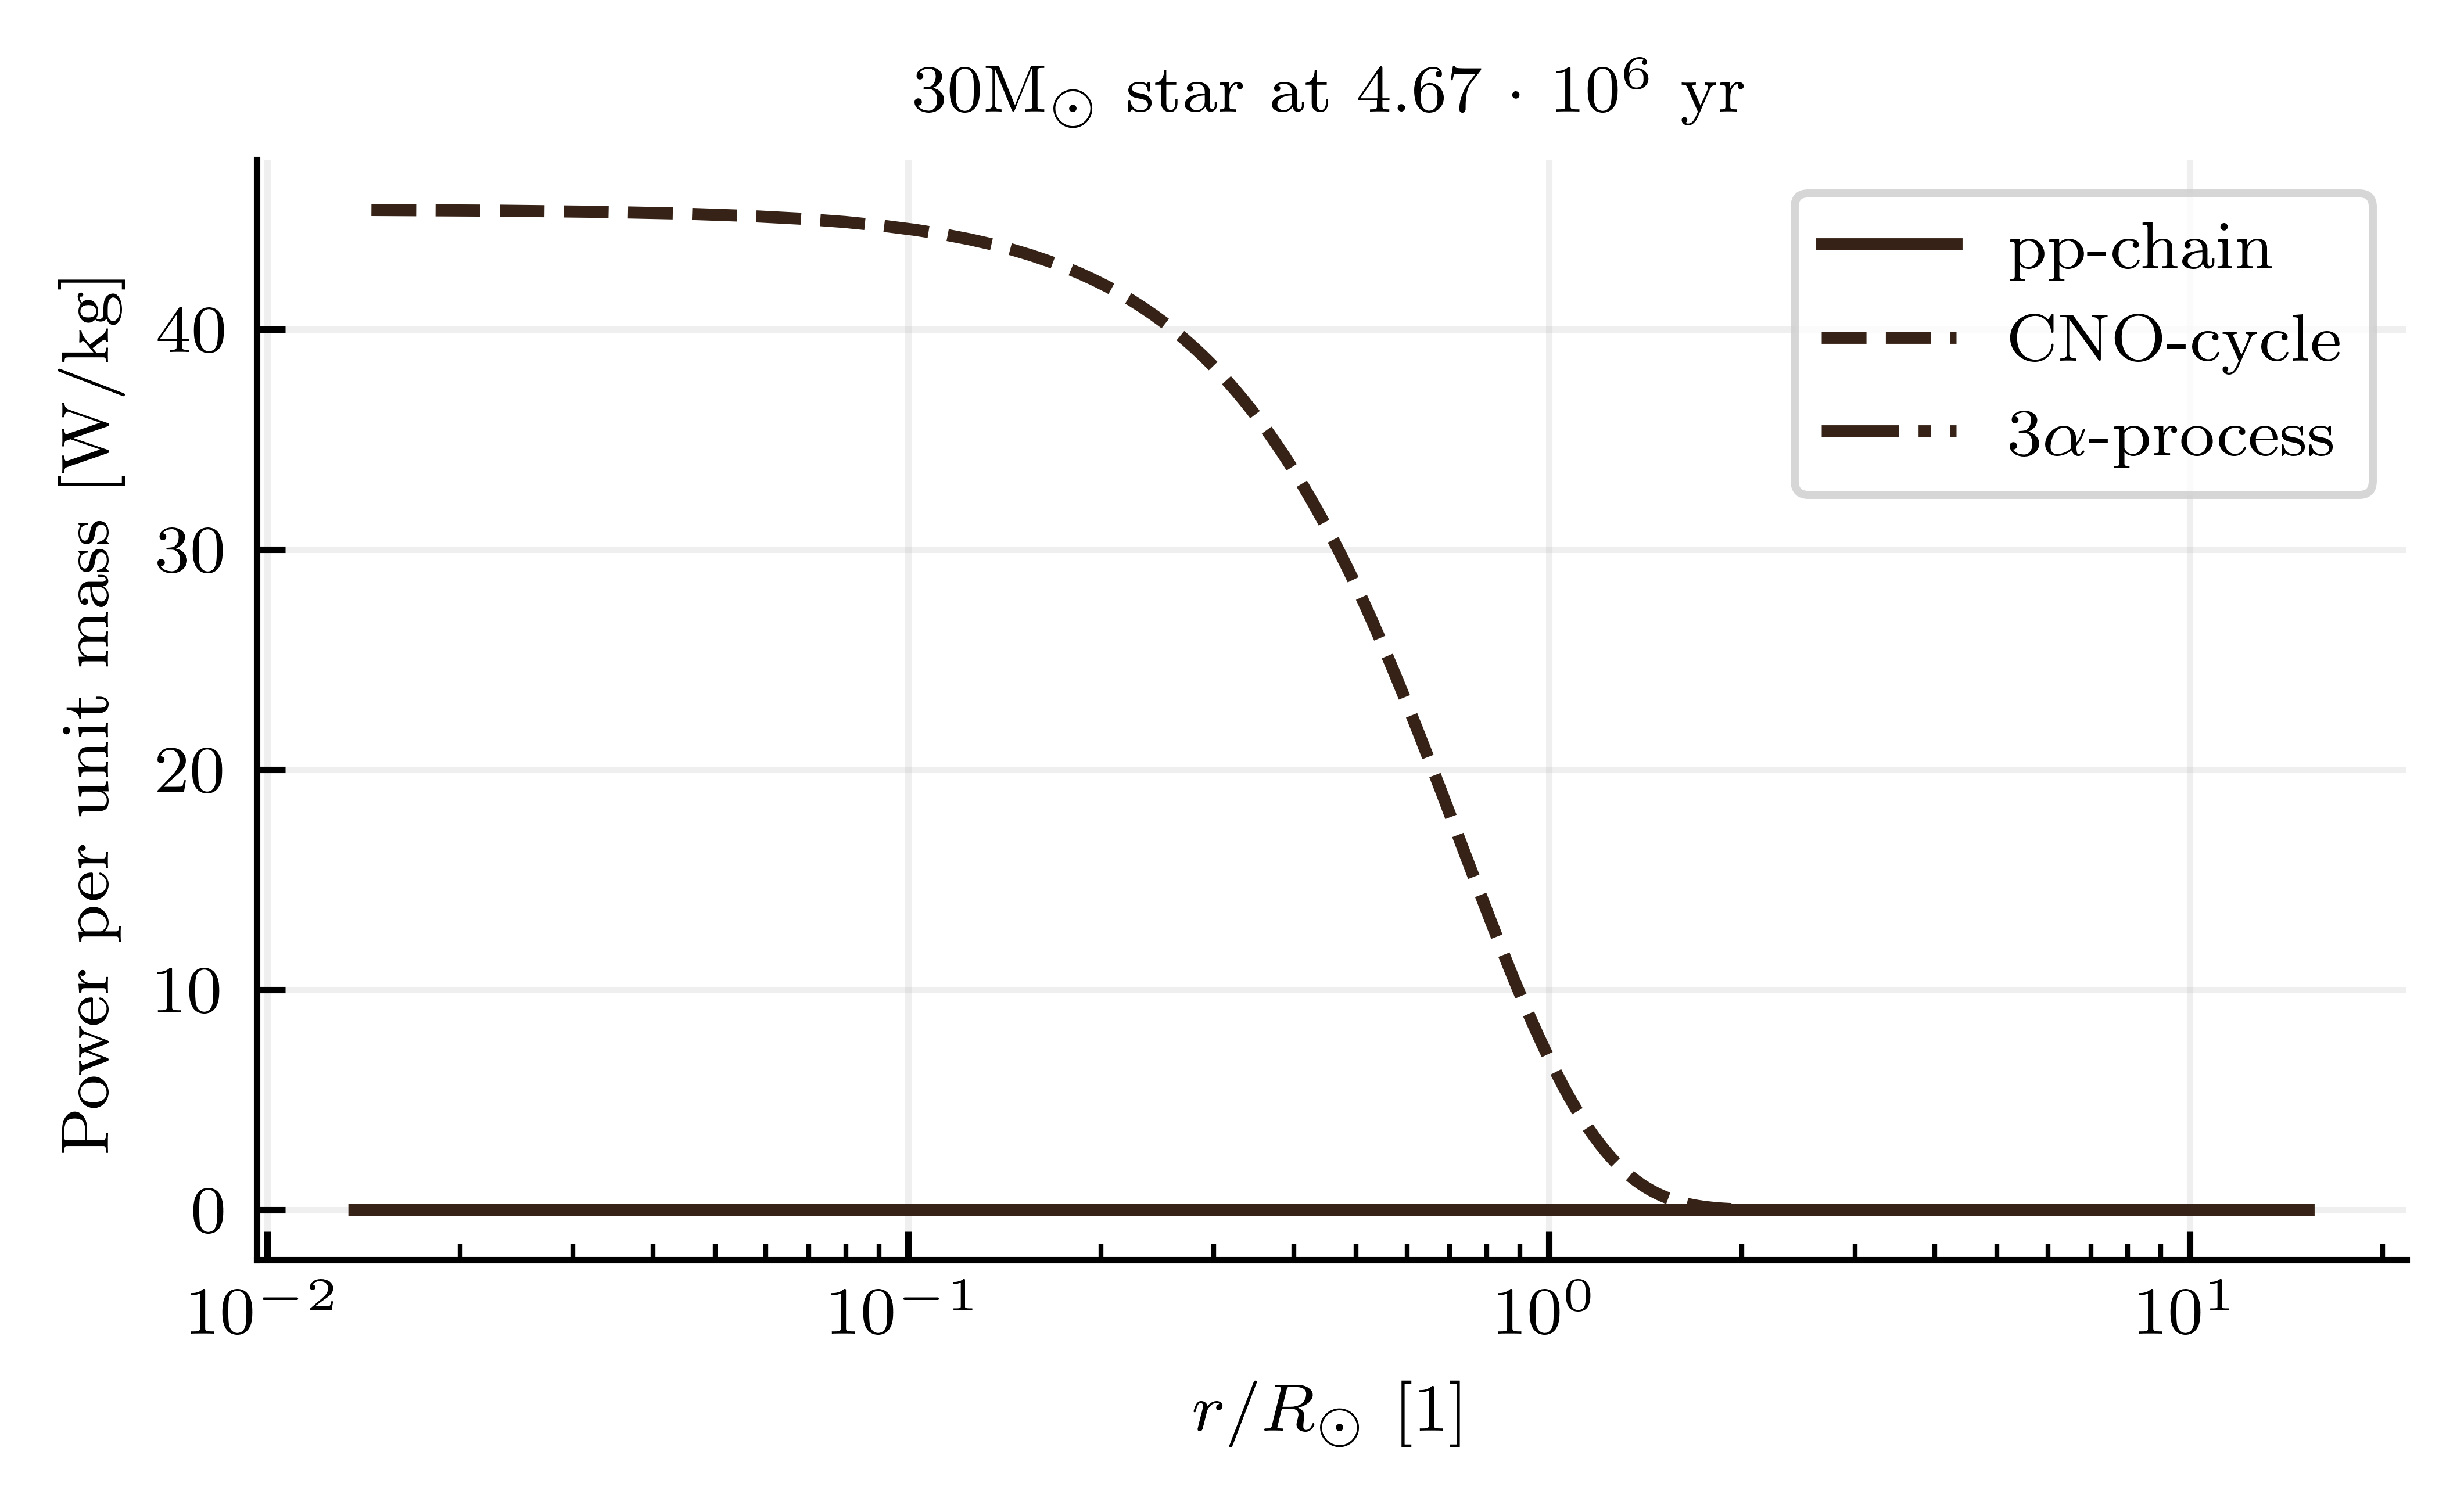

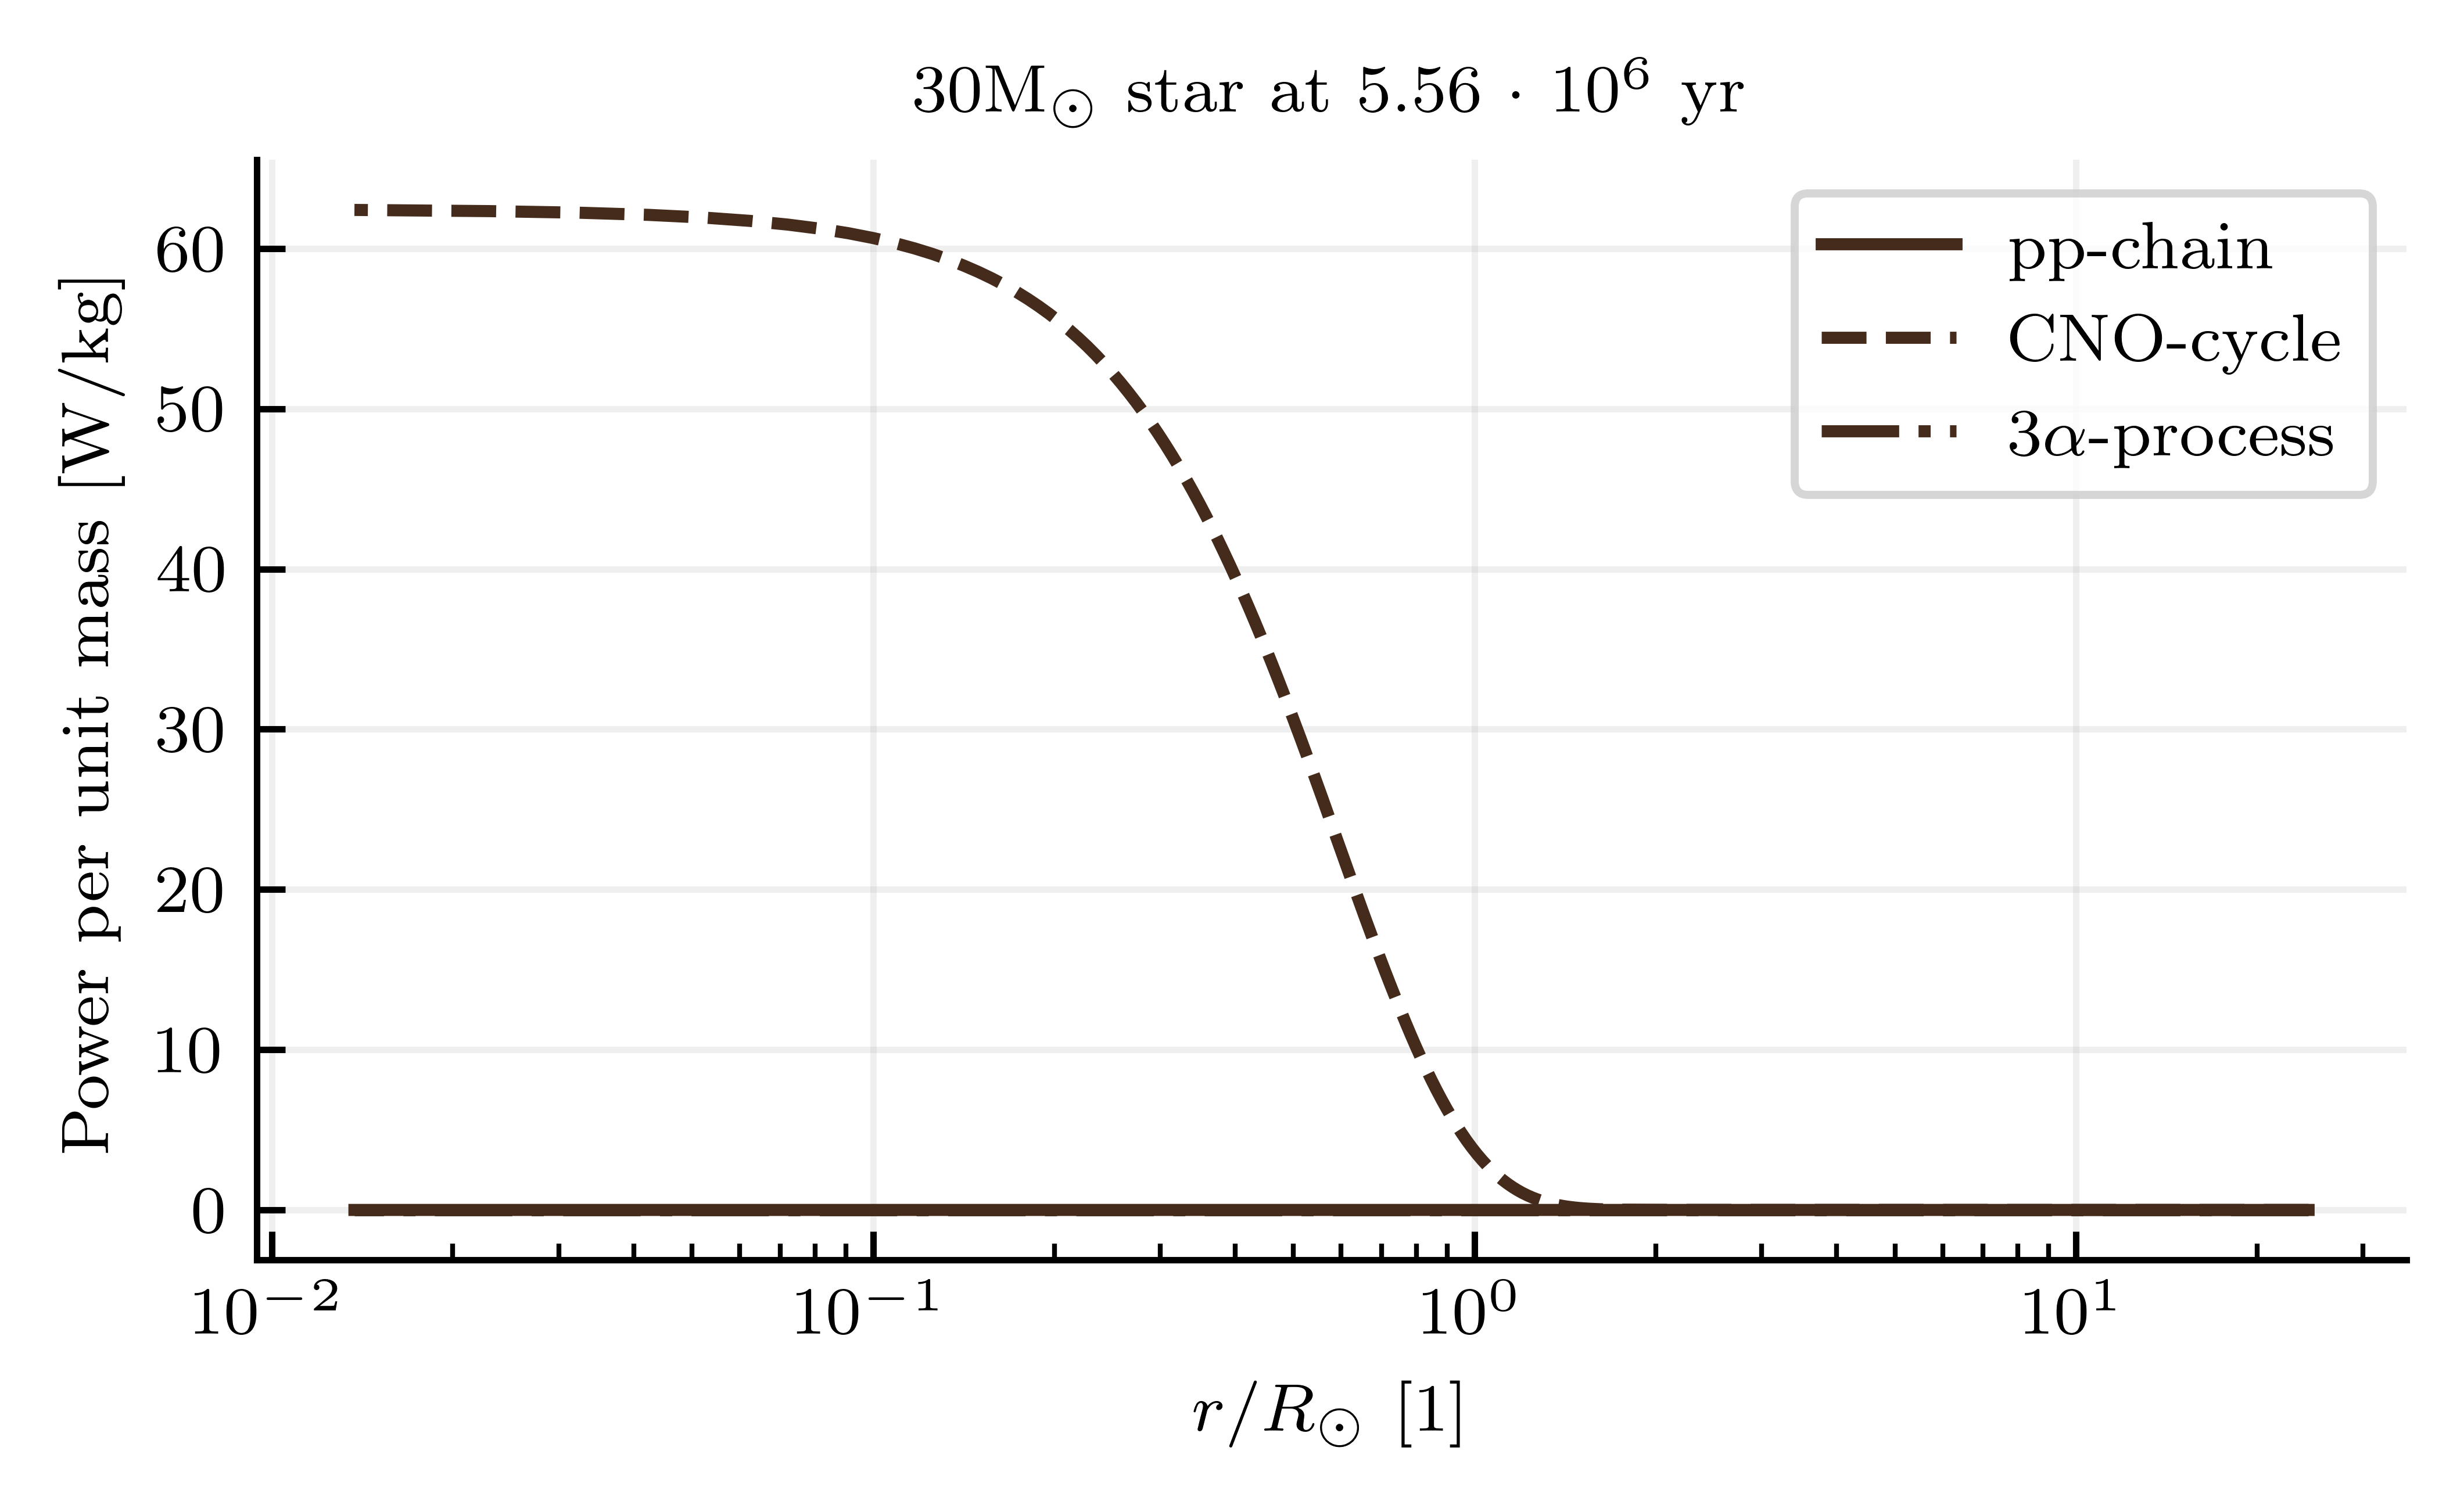

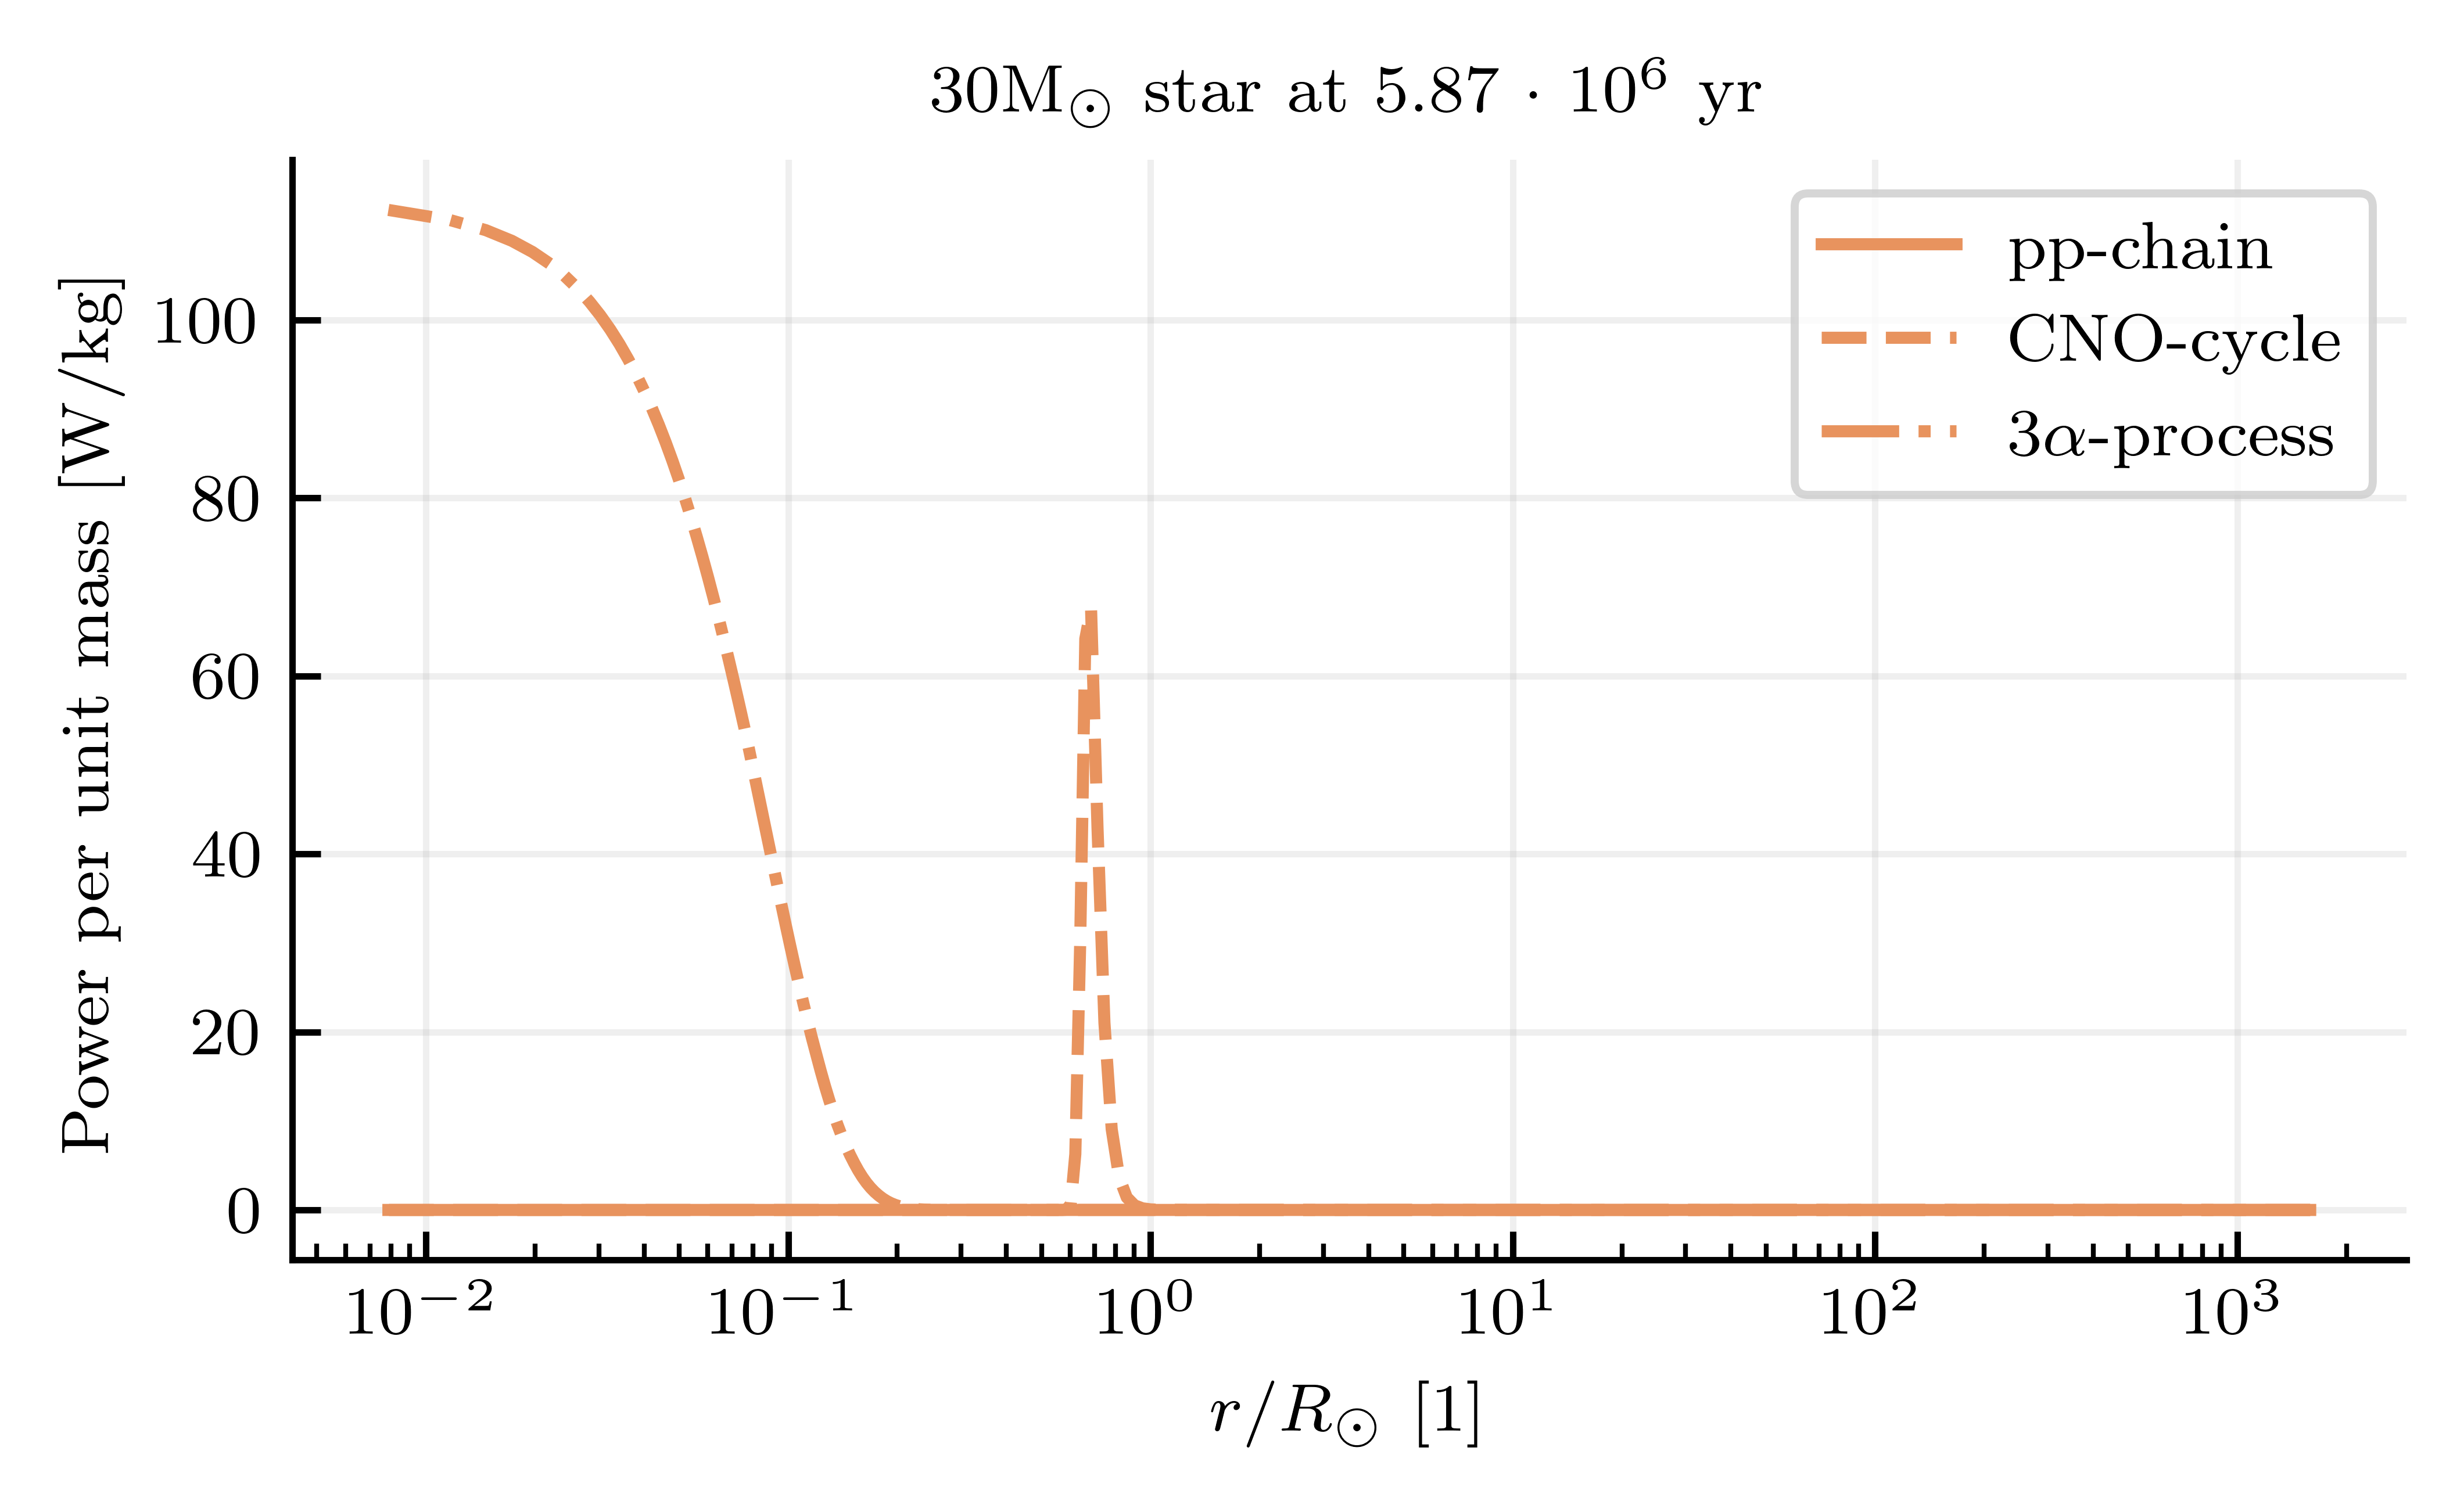

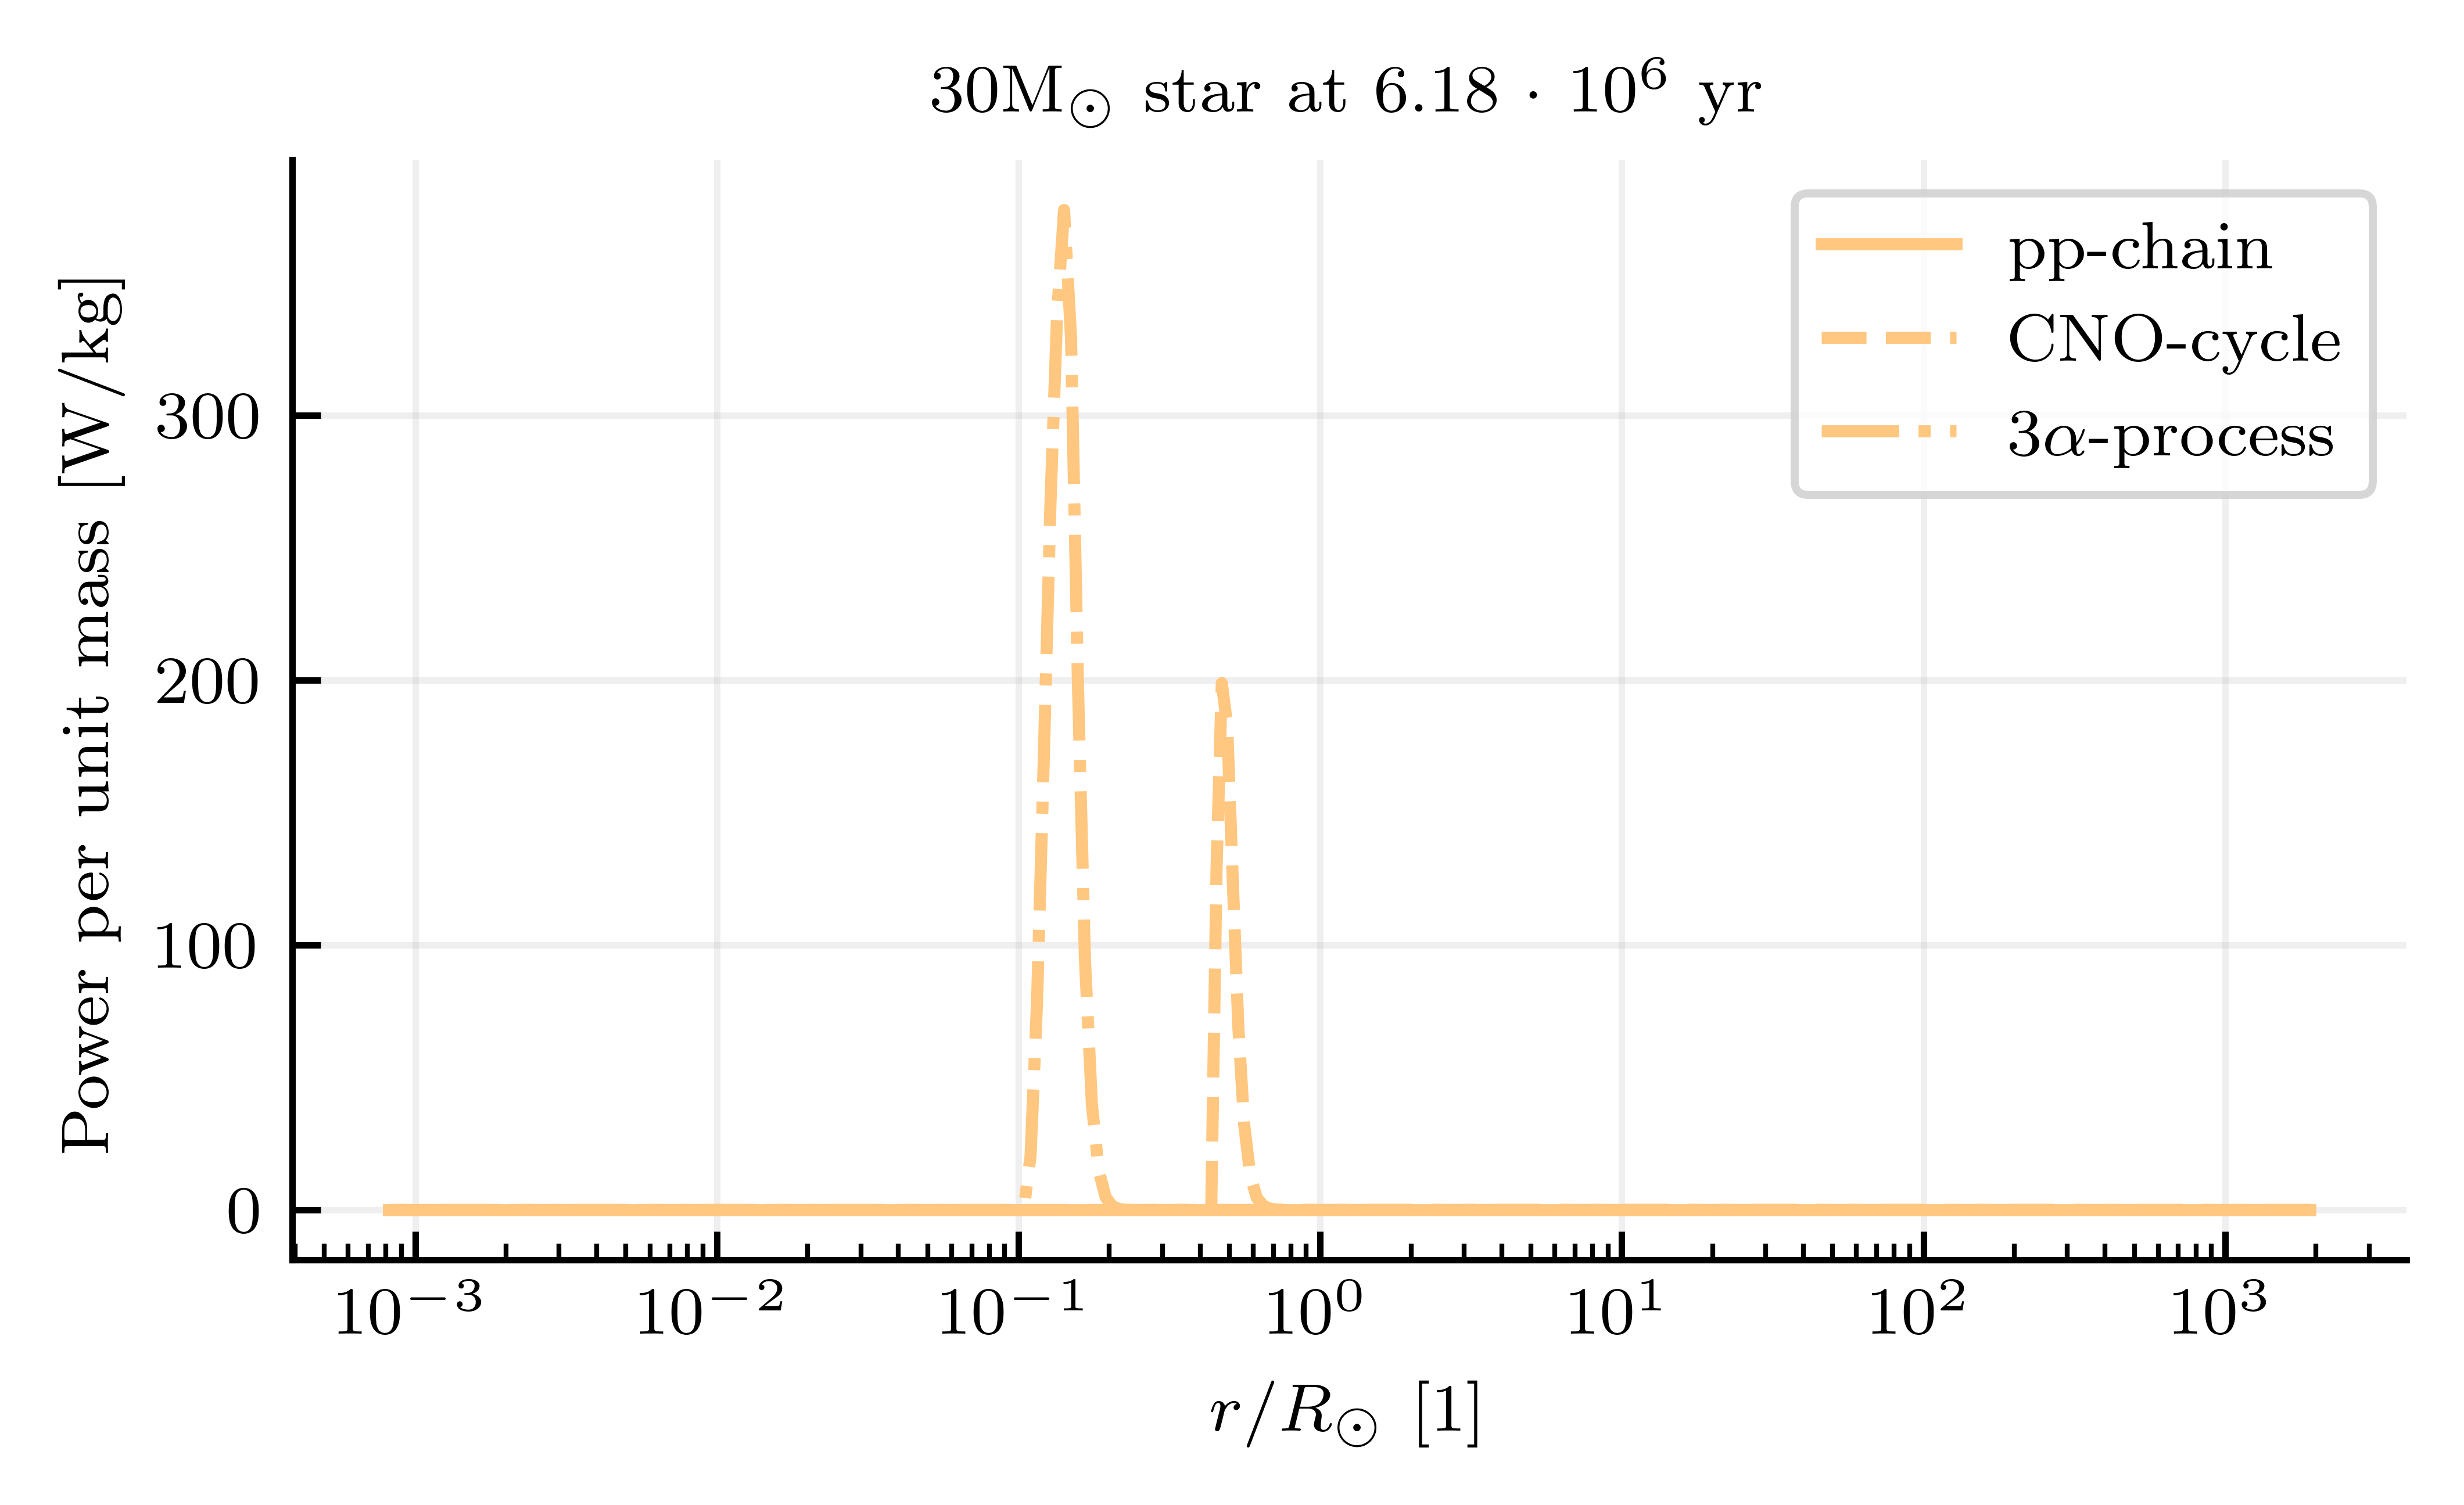

In [11]:
# Data for power per unit mass

data_names = ['2M_0.02','30M_0.02']

def get_structure_files(data_dir, time_frac):
    df = pd.read_csv(data_dir + '/summary.txt', sep=r'\s+', header=None)
    df.columns = col_names
    all_files = os.listdir(os.path.join(data_dir))
    structure_files = [f for f in all_files if f.startswith("structure_")]
    
    # Load first file to extract time column
    df_ref = pd.read_csv(os.path.join(data_dir, structure_files[0]), sep=r'\s+', header=None)
    df_ref.columns = col_names_structure
    
    # Find indices closest to given time fractions
    time_frac_idx = [np.argmin(np.abs(df['t'] - (t * np.max(df['t'])))) for t in time_frac]
    
    formatted_indices = [str(idx).zfill(5) for idx in time_frac_idx]
    filtered_files = [f for f in structure_files if f[10:15] in formatted_indices]
    
    t = [df['t'].values[idx] for idx in time_frac_idx]
    
    return sorted(filtered_files), t

def get_max_num(data_dir):
    all_files = os.listdir(data_dir)
    structure_files = [f for f in all_files if f.startswith("structure_")]
    time_steps = [int(f[10:15]) for f in structure_files]
    max_time_step = max(time_steps) if time_steps else 0
    
    return max_time_step

def plot_rad_contr(data_files, data_dir, max_iter, name, time):

    cmap = cm.copper
    norm = Normalize(vmin=0, vmax=1)
    for i,data_name in enumerate(data_files):
        file_path = os.path.join(data_dir, data_name)
        
        df = pd.read_csv(file_path, sep=r'\s+', header=None)
        df.columns = col_names_structure
        
        r = df['r']
        
        time_percentage = int(data_name[10:15])/max_iter 
        color = cmap(norm(time_percentage)) 
        
        plt.semilogx(r, df['epspp'], color = color, linestyle = '-', label = 'pp-chain')
        plt.ylabel(r"Power per unit mass [$\mathrm{W/kg}$]")
        
        plt.semilogx(r, df['epscno'], color = color, linestyle = '--', label = 'CNO-cycle')
        
        plt.semilogx(r, df['eps3alpha'], color = color, linestyle = '-.', label = r'$3\alpha$-process')
        plt.xlabel(r"$r/R_\odot$ [1]")
        #plt.colorbar(label =r'$t/t_\mathrm{end}$', aspect = 0.8)
        plt.legend()
        plt.grid(alpha=.2)
        plt.title(name + rf' star at {time[i]/1e6:.2f} $\cdot$ $10^6$ yr')
        plt.savefig(FIG_DIR+f'Rad Contr {i}.pdf',bbox_inches='tight')
        plt.show()



time_frac =  [1e-9, 0.55, 0.75, 0.9, 0.95, 1]
        
for i, name in enumerate(data_names):
    full_path = DATA_DIR + name
    max_iter = get_max_num(full_path)
    data_files = get_structure_files(full_path, time_frac)[0]
    time = get_structure_files(full_path, time_frac)[1]
    plot_rad_contr(data_files, full_path, max_iter, plot_title[i], time)
    